In [1]:
!bash init.sh

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘np’: File exists


In [2]:
%cd flowgmm
!pip install -q -e .
!pip install -q timm==0.3.2 torch torchvision
!pip install -q scanpy normflows
!pip install -q pydeseq2
%cd ..

/home/anunay18021/SingleCellClassification/flowgmm


/home/anunay18021/SingleCellClassification


In [3]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions

import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [4]:
!python3 process_dataset/generate_baron_dataset.py

Starting preprocessing...
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
14260
index
A2M       True
A4GALT    True
AADAC     True
AATK      True
ABCA4     True
          ... 
ZSCAN9    True
ZSWIM3    True
ZSWIM4    True
ZYX       True
pk        True
Name: highly_variable, Length: 3000, dtype: bool
Taking common genes...
Common columns 2975


In [5]:

import scanpy as sc
import os
from numpy.random import seed
# from tensorflow import set_random_seed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
dataset_train = 'dataset/Bh.h5ad'
dataset_test = 'dataset/smartseq2.h5ad'
import sys
sys.path.insert(0, '')

from scripts.utils import *

adata_train=sc.read(dataset_train)
adata_test=sc.read(dataset_test)

print("Starting preprocessing...")
train_dic = preprocess(adata_train, min_cells=20,min_genes=50, get_hvgs = True, scale_and_hvgs = True)
test_dic = preprocess(adata_test, min_cells=0, min_genes=0)
print(len(intersection(adata_train.var.index, adata_test.var.index)))
list(adata_train.var.index)[0]

col= [i for i in train_dic['hvg'].index]

train_adata_pp =  train_dic['data']
print(train_dic['hvg'])
test_adata_pp =  test_dic['data'][:, intersection(col, test_dic['data'].var.index)]
train_adata_pp = train_dic['data'][:, intersection(col, train_dic['data'].var.index)]

train_df = train_adata_pp.to_df()
test_df = test_adata_pp.to_df()

## taking common genes
print("Taking common genes...")
final_columns = list(set(train_df.columns).intersection(set(test_df.columns)))
print('Common columns', len(final_columns))
final_columns = [i for i in final_columns if i != 'celltype']
train_df = train_df[final_columns]
test_df = test_df[final_columns]

y_train = train_adata_pp.obs.celltype.to_list()
y_test = test_adata_pp.obs.celltype.to_list()

X_train = train_df.to_numpy()
X_test = test_df.to_numpy()

labels = set(y_train)

mapping = get_mapping(y_train)

y_test = np.array(convert_y_to_mapping(y_test, mapping))

y_train = np.array(convert_y_to_mapping(y_train, mapping))

with open('dataset/np/X_train.pkl', 'wb') as fh:
    pickle.dump(X_train, fh)

with open('dataset/np/X_test.pkl', 'wb') as fh:
    pickle.dump(X_test, fh)

with open('dataset/np/y_test.pkl', 'wb') as fh:
    pickle.dump(y_test, fh)

with open('dataset/np/y_train.pkl', 'wb') as fh:
    pickle.dump(y_train, fh)

Starting preprocessing...


/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


14260
index
A2M       True
A4GALT    True
AADAC     True
AATK      True
ABCA4     True
          ... 
ZSCAN9    True
ZSWIM3    True
ZSWIM4    True
ZYX       True
pk        True
Name: highly_variable, Length: 3000, dtype: bool
Taking common genes...
Common columns 2975


In [6]:
y = calculate_freq(y_train)

In [7]:
y

{9: 958,
 12: 2525,
 3: 601,
 1: 284,
 10: 1077,
 6: 2326,
 13: 18,
 2: 255,
 4: 252,
 0: 173,
 7: 55,
 11: 13,
 5: 25,
 8: 7}

In [6]:
labels_y_train = train_adata_pp.obs.celltype.to_list()

In [7]:
%cd flowgmm

/home/anunay18021/SingleCellClassification/flowgmm


In [8]:


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.dpi'] = 300

# from flow_ssl.realnvp.realnvp_toy import ToyRealNVP
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.data import make_circles_ssl, make_moons_ssl, make_dataset_from_img, make_dataset_from_npz
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

from itertools import chain

%load_ext autoreload
%autoreload 2

In [9]:
def get_means(means_type, num_means=10, shape=(3, 32, 32), r=1, trainloader=None, device=None, net=None):

    D = np.prod(shape)
    means = torch.zeros((num_means, D)).to(device)

    if means_type == "pixel_const":
        for i in range(num_means):
            means[i, :] = r * (i-4)

    elif means_type == "split_dims":
        mean_portion = D // num_means
        for i in range(num_means):
            means[i, i*mean_portion:(i+1)*mean_portion] = r

    elif means_type == "random":
        for i in range(num_means):
            means[i] = r * torch.randn(D)

    else:
        raise NotImplementedError(means_type)

    return means

In [10]:
import pickle
with open('../dataset/np/X_train.pkl', 'rb') as fh:
    X_train = pickle.load(fh)

with open('../dataset/np/X_test.pkl', 'rb') as fh:
    X_test = pickle.load(fh)

with open('../dataset/np/y_test.pkl', 'rb') as fh:
    y_test = pickle.load(fh)

with open('../dataset/np/y_train.pkl', 'rb') as fh:
    y_train = pickle.load(fh)

In [11]:
print(set(list(y_train)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


In [12]:
device = torch.device("cuda")

In [13]:
r = 3.5
means = torch.tensor([[-r, -r], [r, r]])

# r = 3.5
# n_classes = 2
means = get_means('random' , r=0.8*0.7, num_means=len(set(list(y_train))), trainloader=None, shape=(X_train.shape[1]), device=device).to(device)

prior = SSLGaussMixture(means=means, device=device)


flow = RealNVPTabular(num_coupling_layers=7, in_dim=X_train.shape[1], num_layers=3, hidden_dim=1024).to(device)
loss_fn = FlowLoss(prior).to(device)
# get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=6, inner_layers=2)

In [14]:
data = X_train
labels = y_train

In [25]:
torch.set_num_threads(10)

In [28]:
lr_init = 2e-4
epochs = 1500

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 30

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init,
                             weight_decay=1e-2)
step_size = 7500
for t in range(epochs):
    loss_total= []
#     batch_idx = np.random.choice(n_ul, size=batch_size)
#     batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    for m in range(batch_size//step_size):
      batch_x = labeled_data[m*step_size: (m + 1)*step_size]
      batch_y = labeled_labels[m*step_size: (m + 1)*step_size]
      batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      z = flow(batch_x).to(device)
      sldj = flow.logdet().to(device)


      loss = loss_fn(z, sldj, batch_y)

      optimizer.zero_grad()
      loss.backward()#retain_graph=True)
      optimizer.step()

      loss_total.append(loss)

      if t == int(epochs * 0.5) or t == int(epochs * 0.8):
          for p in optimizer.param_groups:
              p["lr"] /= 10
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % float(sum(loss_total)/len(loss_total)),end="\n")
    if t % (print_freq*10) == 0:
        print()

iter 0: loss = 17717.805



iter 30: loss = 18597.074
iter 60: loss = 17625.666
iter 90: loss = 17282.895
iter 120: loss = 16950.057
iter 150: loss = 17083.717
iter 180: loss = 17814.246
iter 210: loss = 16673.773
iter 240: loss = 17976.867
iter 270: loss = 16625.043
iter 300: loss = 17722.119

iter 330: loss = 16471.016
iter 360: loss = 16856.330
iter 390: loss = 16007.855
iter 420: loss = 17747.990
iter 450: loss = 16405.625
iter 480: loss = 15905.893
iter 510: loss = 16434.912
iter 540: loss = 15760.122
iter 570: loss = 15925.771
iter 600: loss = 15465.231

iter 630: loss = 19977.182
iter 660: loss = 18605.648
iter 690: loss = 17527.295
iter 720: loss = 17026.891
iter 750: loss = 16857.193
iter 780: loss = 16452.453
iter 810: loss = 16385.740
iter 840: loss = 16342.078
iter 870: loss = 16302.509
iter 900: loss = 16264.630

iter 930: loss = 16227.876
iter 960: loss = 16192.018
iter 990: loss = 16156.912
iter 1020: loss = 16122.496
iter 1050: loss = 16088.727
iter 1080: loss = 16055.643
iter 1110: loss = 16023.2

In [29]:
torch.save(flow.state_dict(), "flow_baron.pt")
torch.save(loss_fn.state_dict(), "loss_fn_baron.pt")

In [30]:
flow.load_state_dict(torch.load("flow_baron.pt"))
loss_fn.load_state_dict(torch.load("loss_fn_baron.pt"))

<All keys matched successfully>

In [31]:
data, labels = X_train, y_train
# inv_list = []
# for i in range(data.shape[0]//60000):
#   inv_list.append(flow(torch.from_numpy(data[i*6000:(i+1)*6000]).to(device)).cpu().detach().numpy())

In [49]:
freq = calculate_freq(y_train)
print(freq)
rev_mapping = {}
for i in mapping:
  rev_mapping[mapping[i]] = i
print(rev_mapping)

{1: 958, 13: 2525, 2: 601, 11: 284, 5: 1077, 3: 2326, 10: 18, 4: 255, 6: 252, 8: 173, 9: 55, 12: 13, 7: 25, 0: 7}
{0: 't_cell', 1: 'acinar', 2: 'delta', 3: 'alpha', 4: 'gamma', 5: 'ductal', 6: 'endothelial', 7: 'mast', 8: 'quiescent_stellate', 9: 'macrophage', 10: 'epsilon', 11: 'activated_stellate', 12: 'schwann', 13: 'beta'}


In [81]:
def get_avg_dist(X):
    avg_dist = np.zeros((X.shape[0], ))
    for i in range(X.shape[0]):
        avg_dist[i] = np.mean(np.sqrt((X[i,0] - X[:,0])**2 + (X[i,1] - X[:,1])**2))
    return avg_dist
        
            

In [75]:
def get_samples_to_generate(freq, generate_upper_limit):
  samples_to_generate = {}
  for i in freq:
    if freq[i] >= generate_upper_limit:
      continue
    else:
      samples_to_generate[i] = generate_upper_limit - freq[i]
  return samples_to_generate

In [34]:
def generate_data(freq, generate_upper_limit, true_labels, data, x_dist = True):
  samples_to_generate = get_samples_to_generate(freq, generate_upper_limit)
  zs = []
  labels = []
  for i in samples_to_generate:
      z = loss_fn.prior.sample((samples_to_generate[i],), gaussian_id=i).cpu().numpy()
      labels.extend([rev_mapping[i]]*samples_to_generate[i])
      zs.append(z)
  zs = np.concatenate( zs, axis=0 )
  if x_dist:
    zs = flow.inverse(torch.from_numpy(zs).cuda().float()).cpu().detach().numpy()
  y_synthetic = true_labels + labels
  data_synth = np.concatenate((data, zs), axis = 0)
  return data_synth, y_synthetic




In [140]:
def remove_outliers(X, y):
    dist = get_avg_dist(X)
    mean = dist.mean()
    std = dist.std()
    index = np.where((mean - 3*std <= dist) & (mean + 3*std >= dist))
    X_new = X[index, :][0,:,:]
    Y_new = y[index]
    z_adata_pp = sc.AnnData(X=X_new, obs={"celltype": Y_new})
    z_adata_pp.obsm['X_tsne'] = X_new
    return z_adata_pp

In [158]:
def plot_tsne_data(X, labels, title):
  z_adata_pp = sc.AnnData(X=X, obs={"celltype": np.array(labels)})
  z_adata_pp.obsm['z_samples'] = X
  sc.tl.tsne(z_adata_pp, use_rep= 'z_samples', random_state=0)
  z_adata_pp = remove_outliers(z_adata_pp.obsm['X_tsne'], z_adata_pp.obs['celltype'].to_numpy())
  with plt.rc_context({'figure.figsize': (5, 5)}):
    sc.pl.tsne(z_adata_pp,
               color='celltype',
               add_outline=True,
               legend_fontsize=14,
               legend_fontoutline=2,
               frameon=False,
               title=title,
               size = 50,
               palette="tab20b",
              )

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


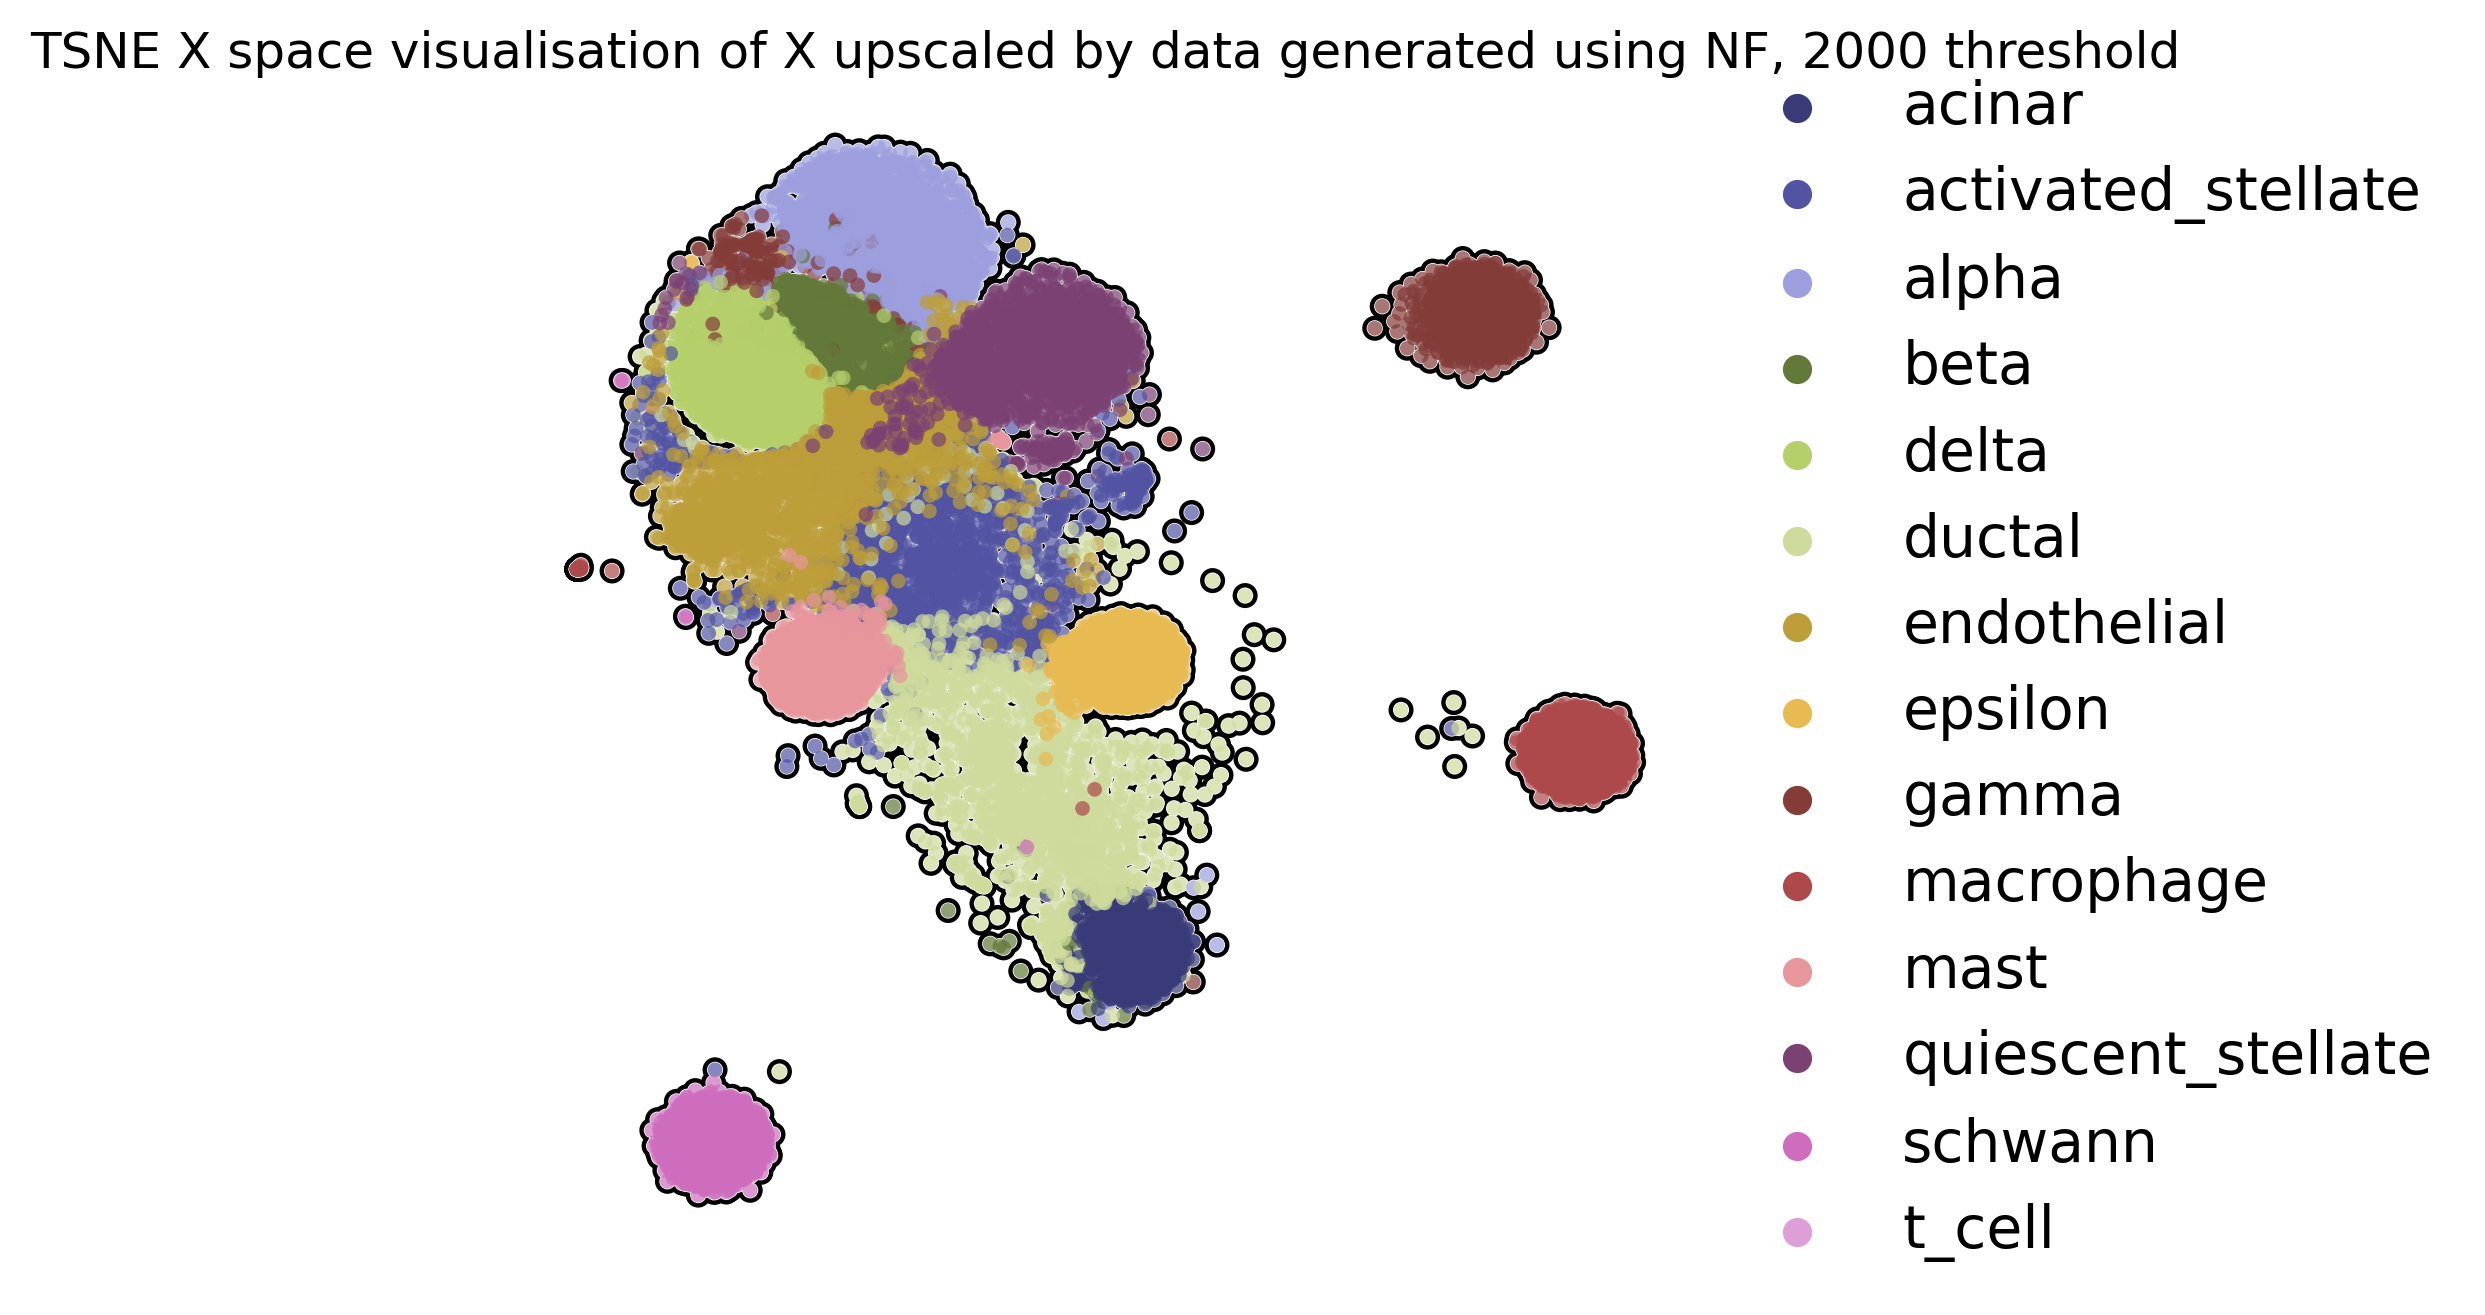

In [160]:
generated_data, generated_labels = generate_data(freq, 2000, train_adata_pp.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 2000 threshold")

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


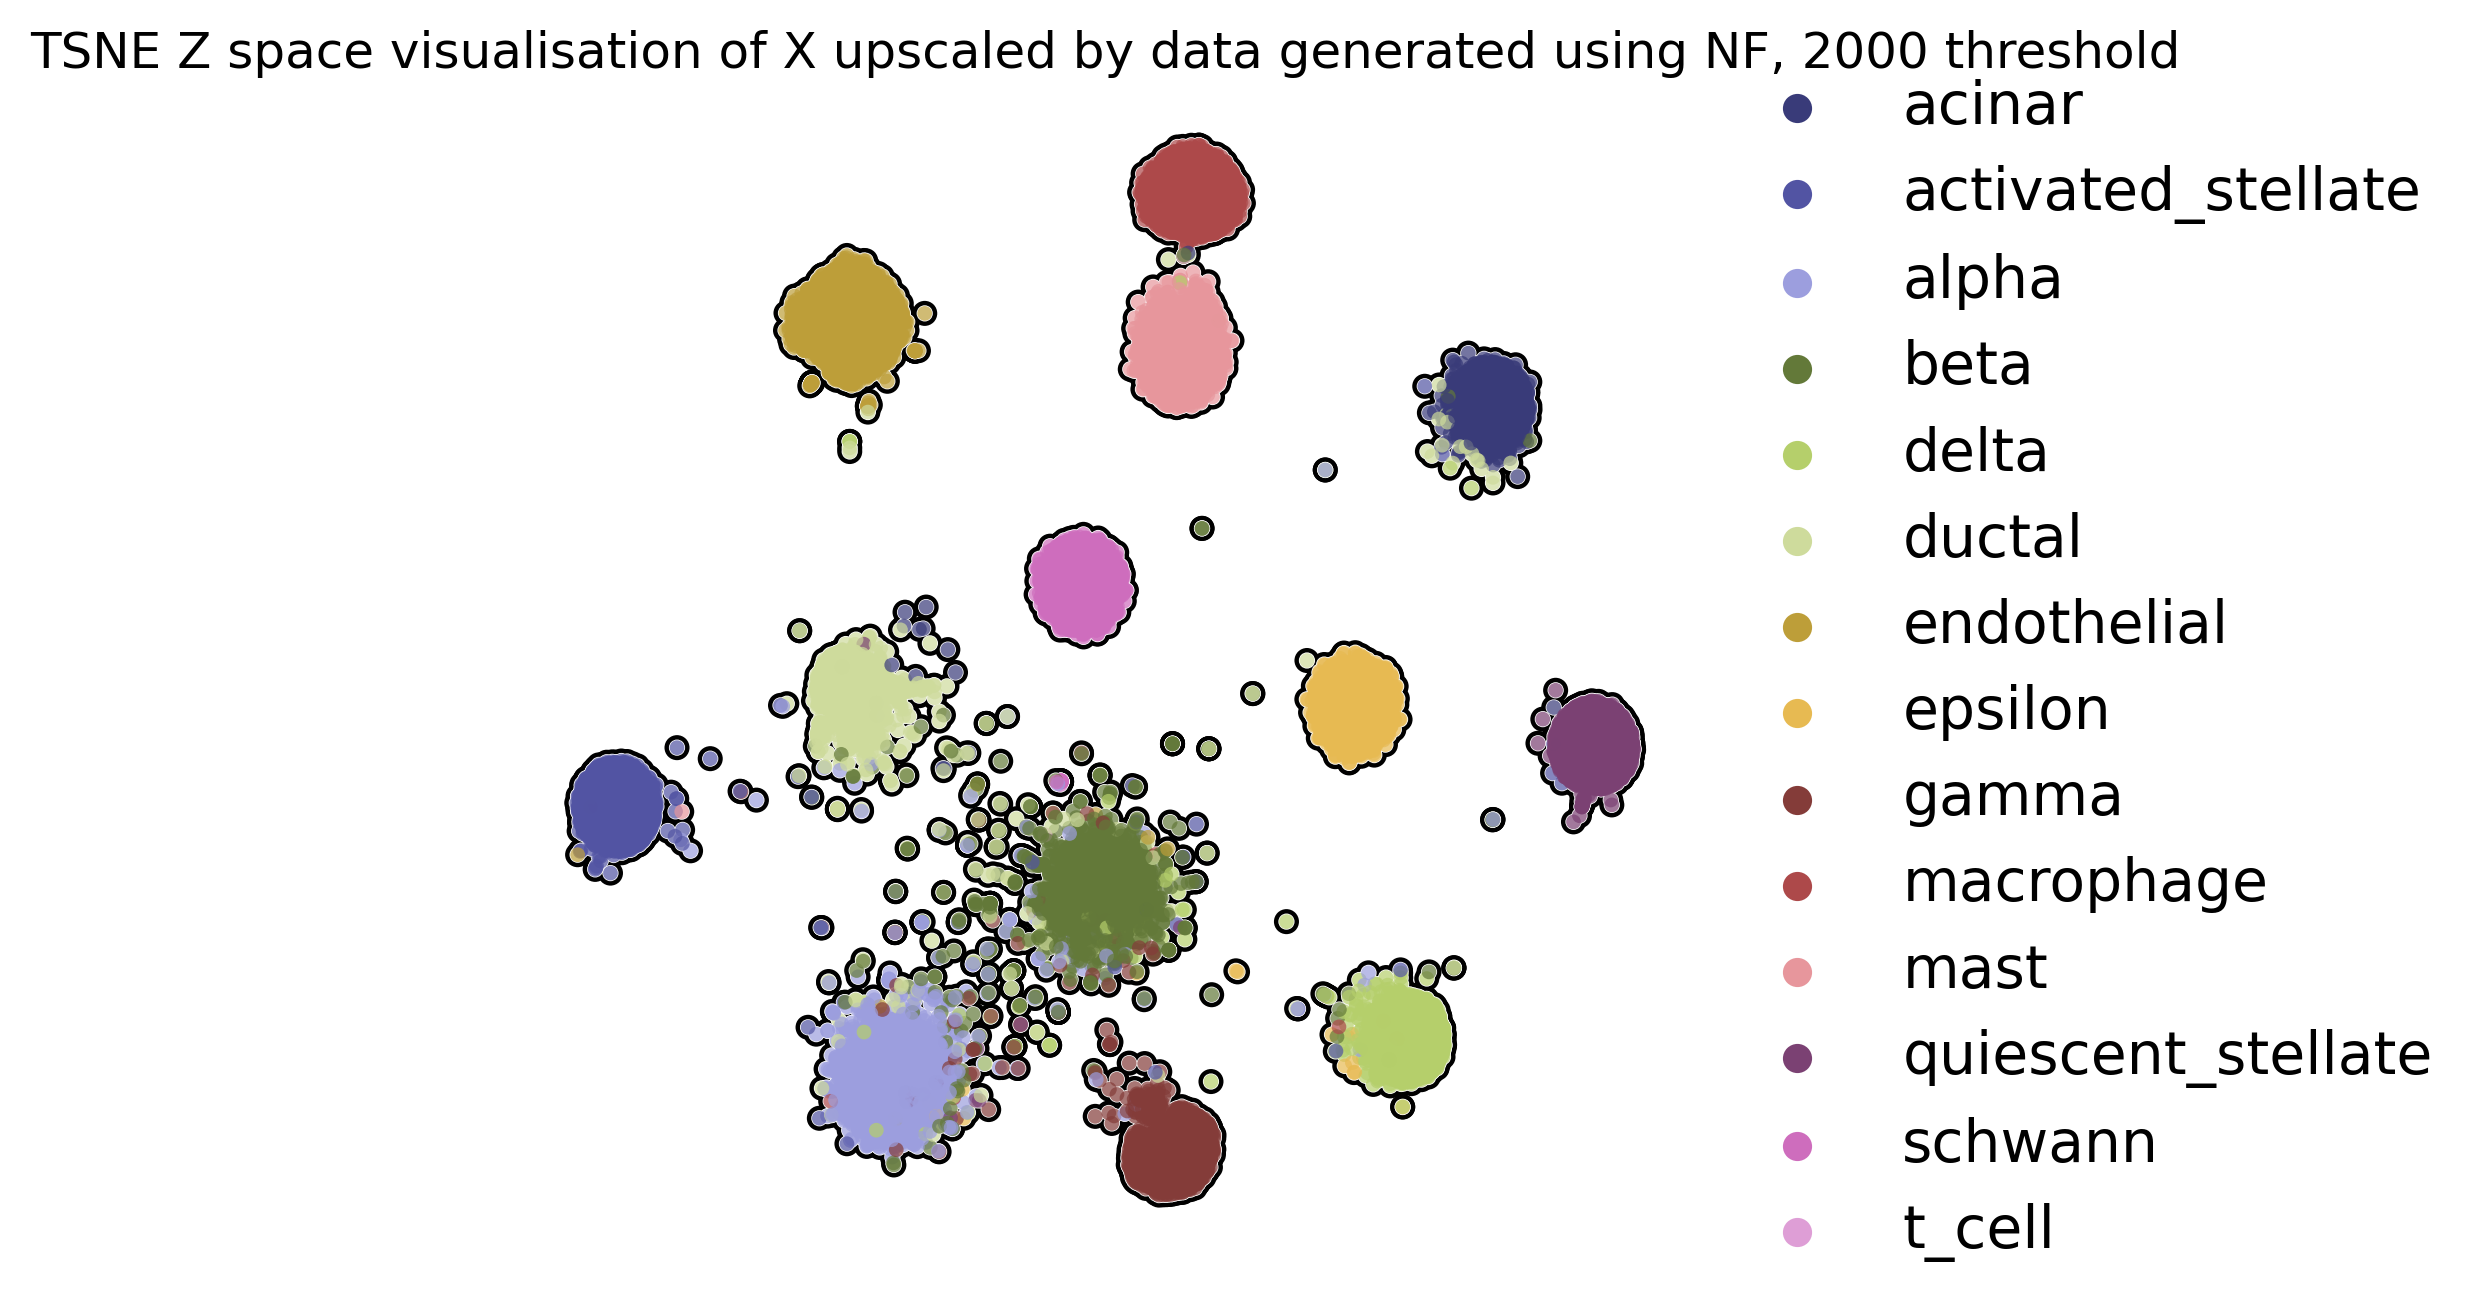

In [161]:
inv = flow(torch.from_numpy(data).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 2000, train_adata_pp.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 2000 threshold")

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


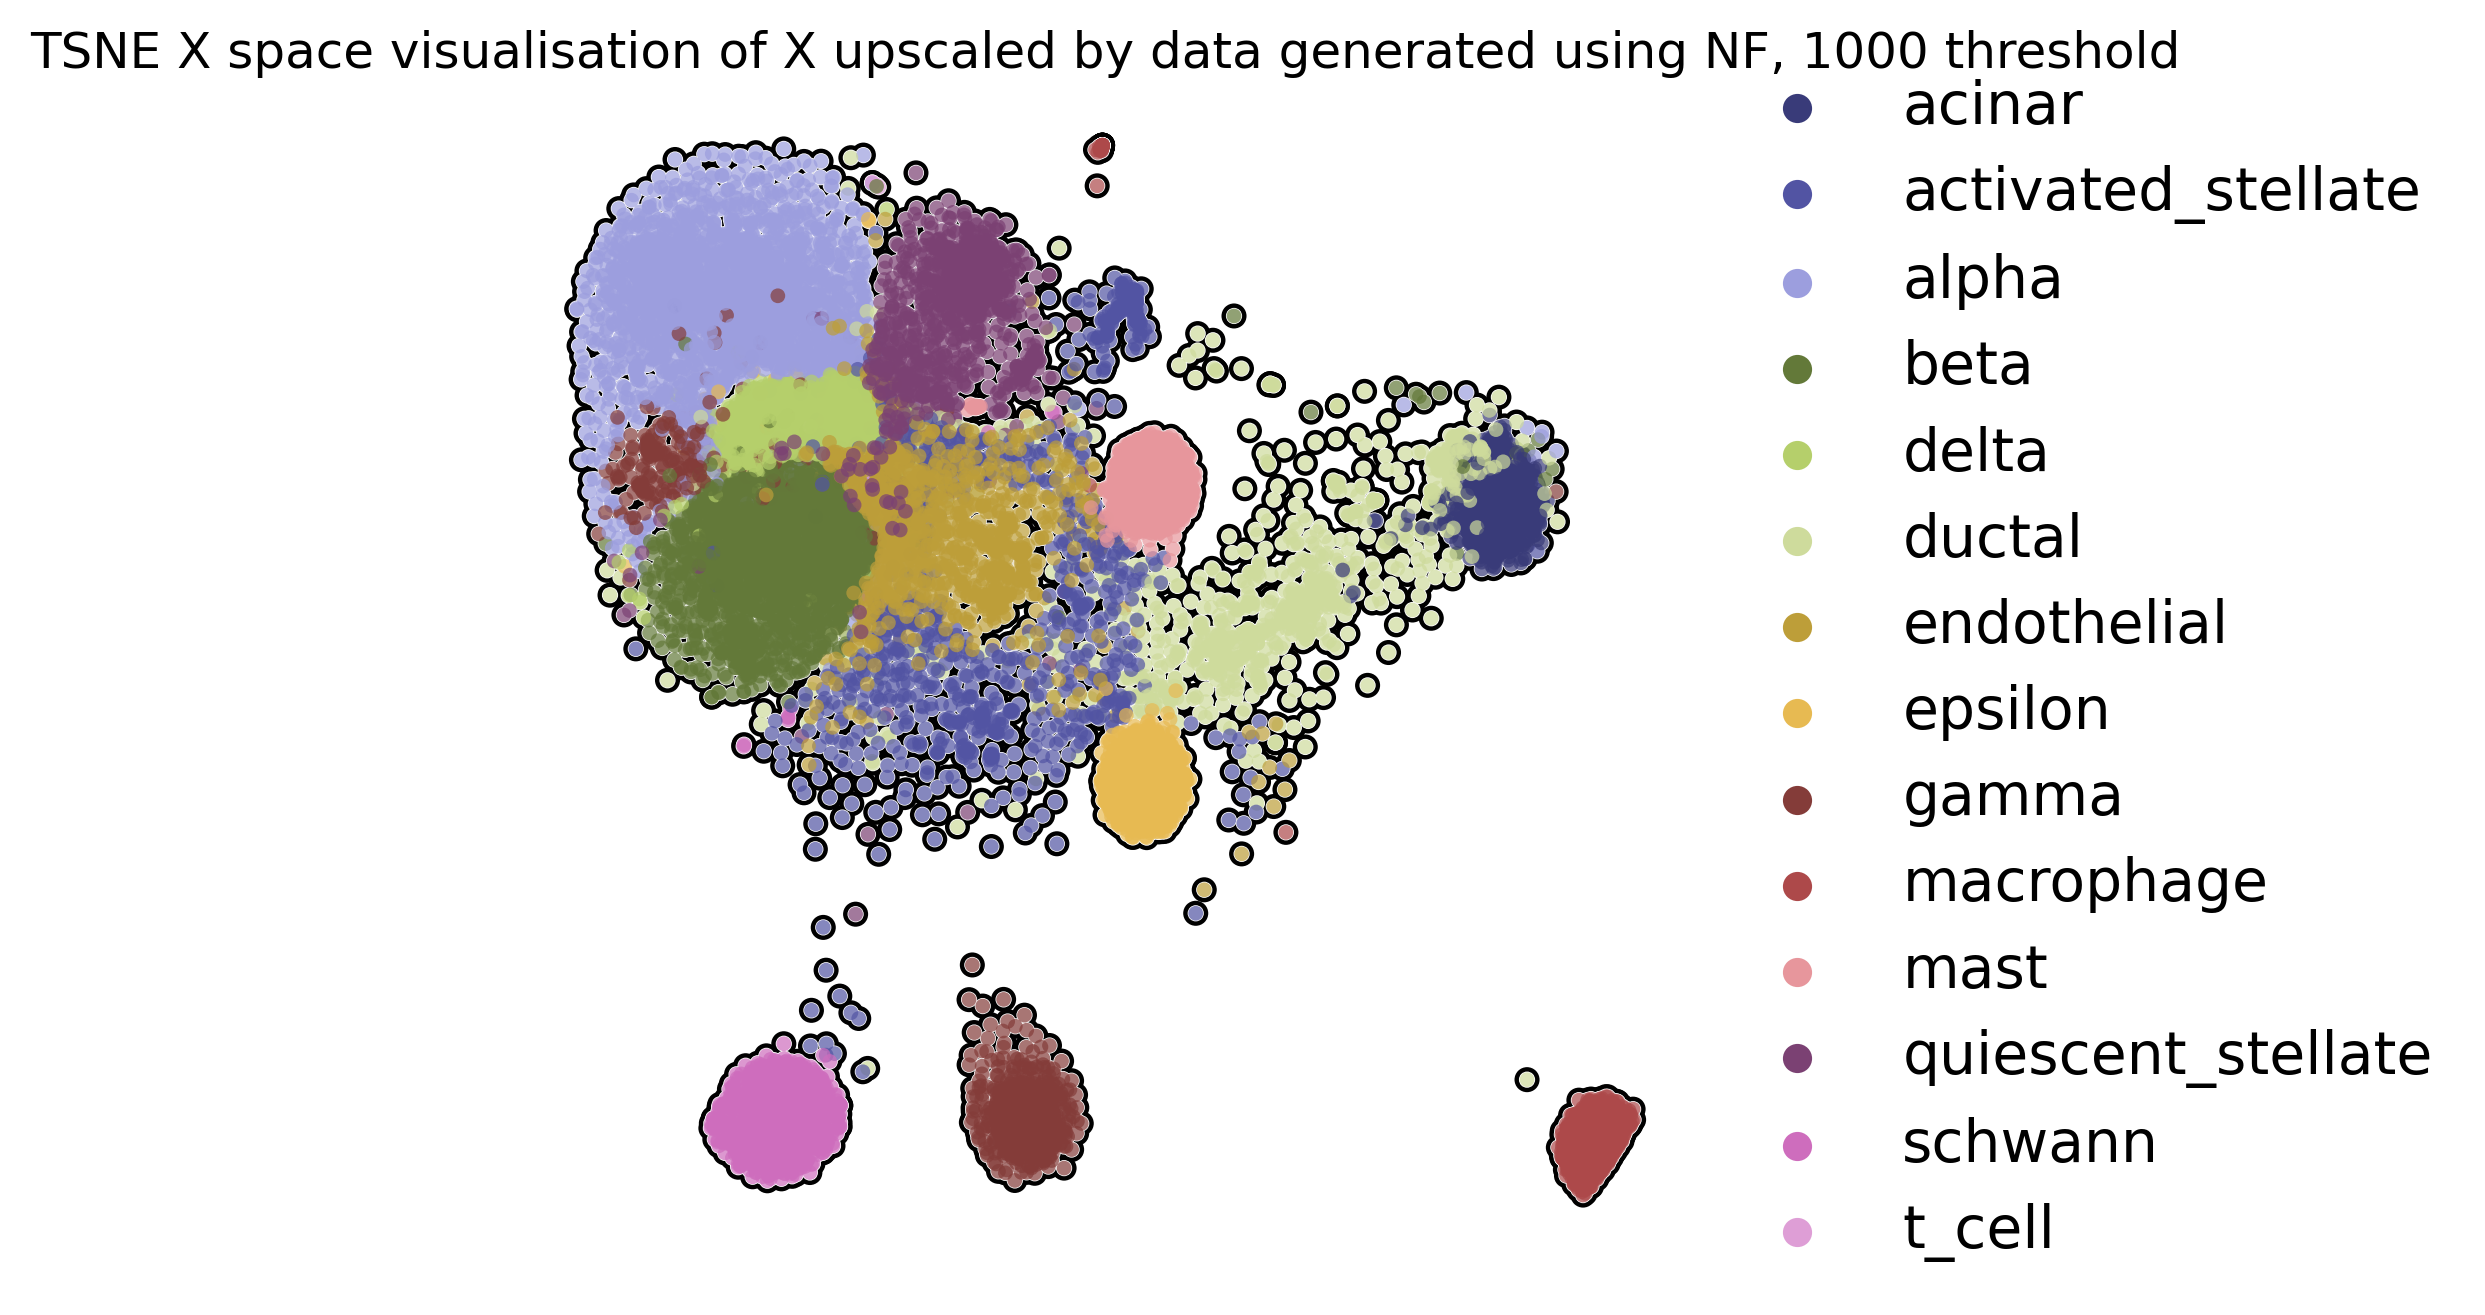

In [162]:
generated_data, generated_labels = generate_data(freq, 1000, train_adata_pp.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 1000 threshold")

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


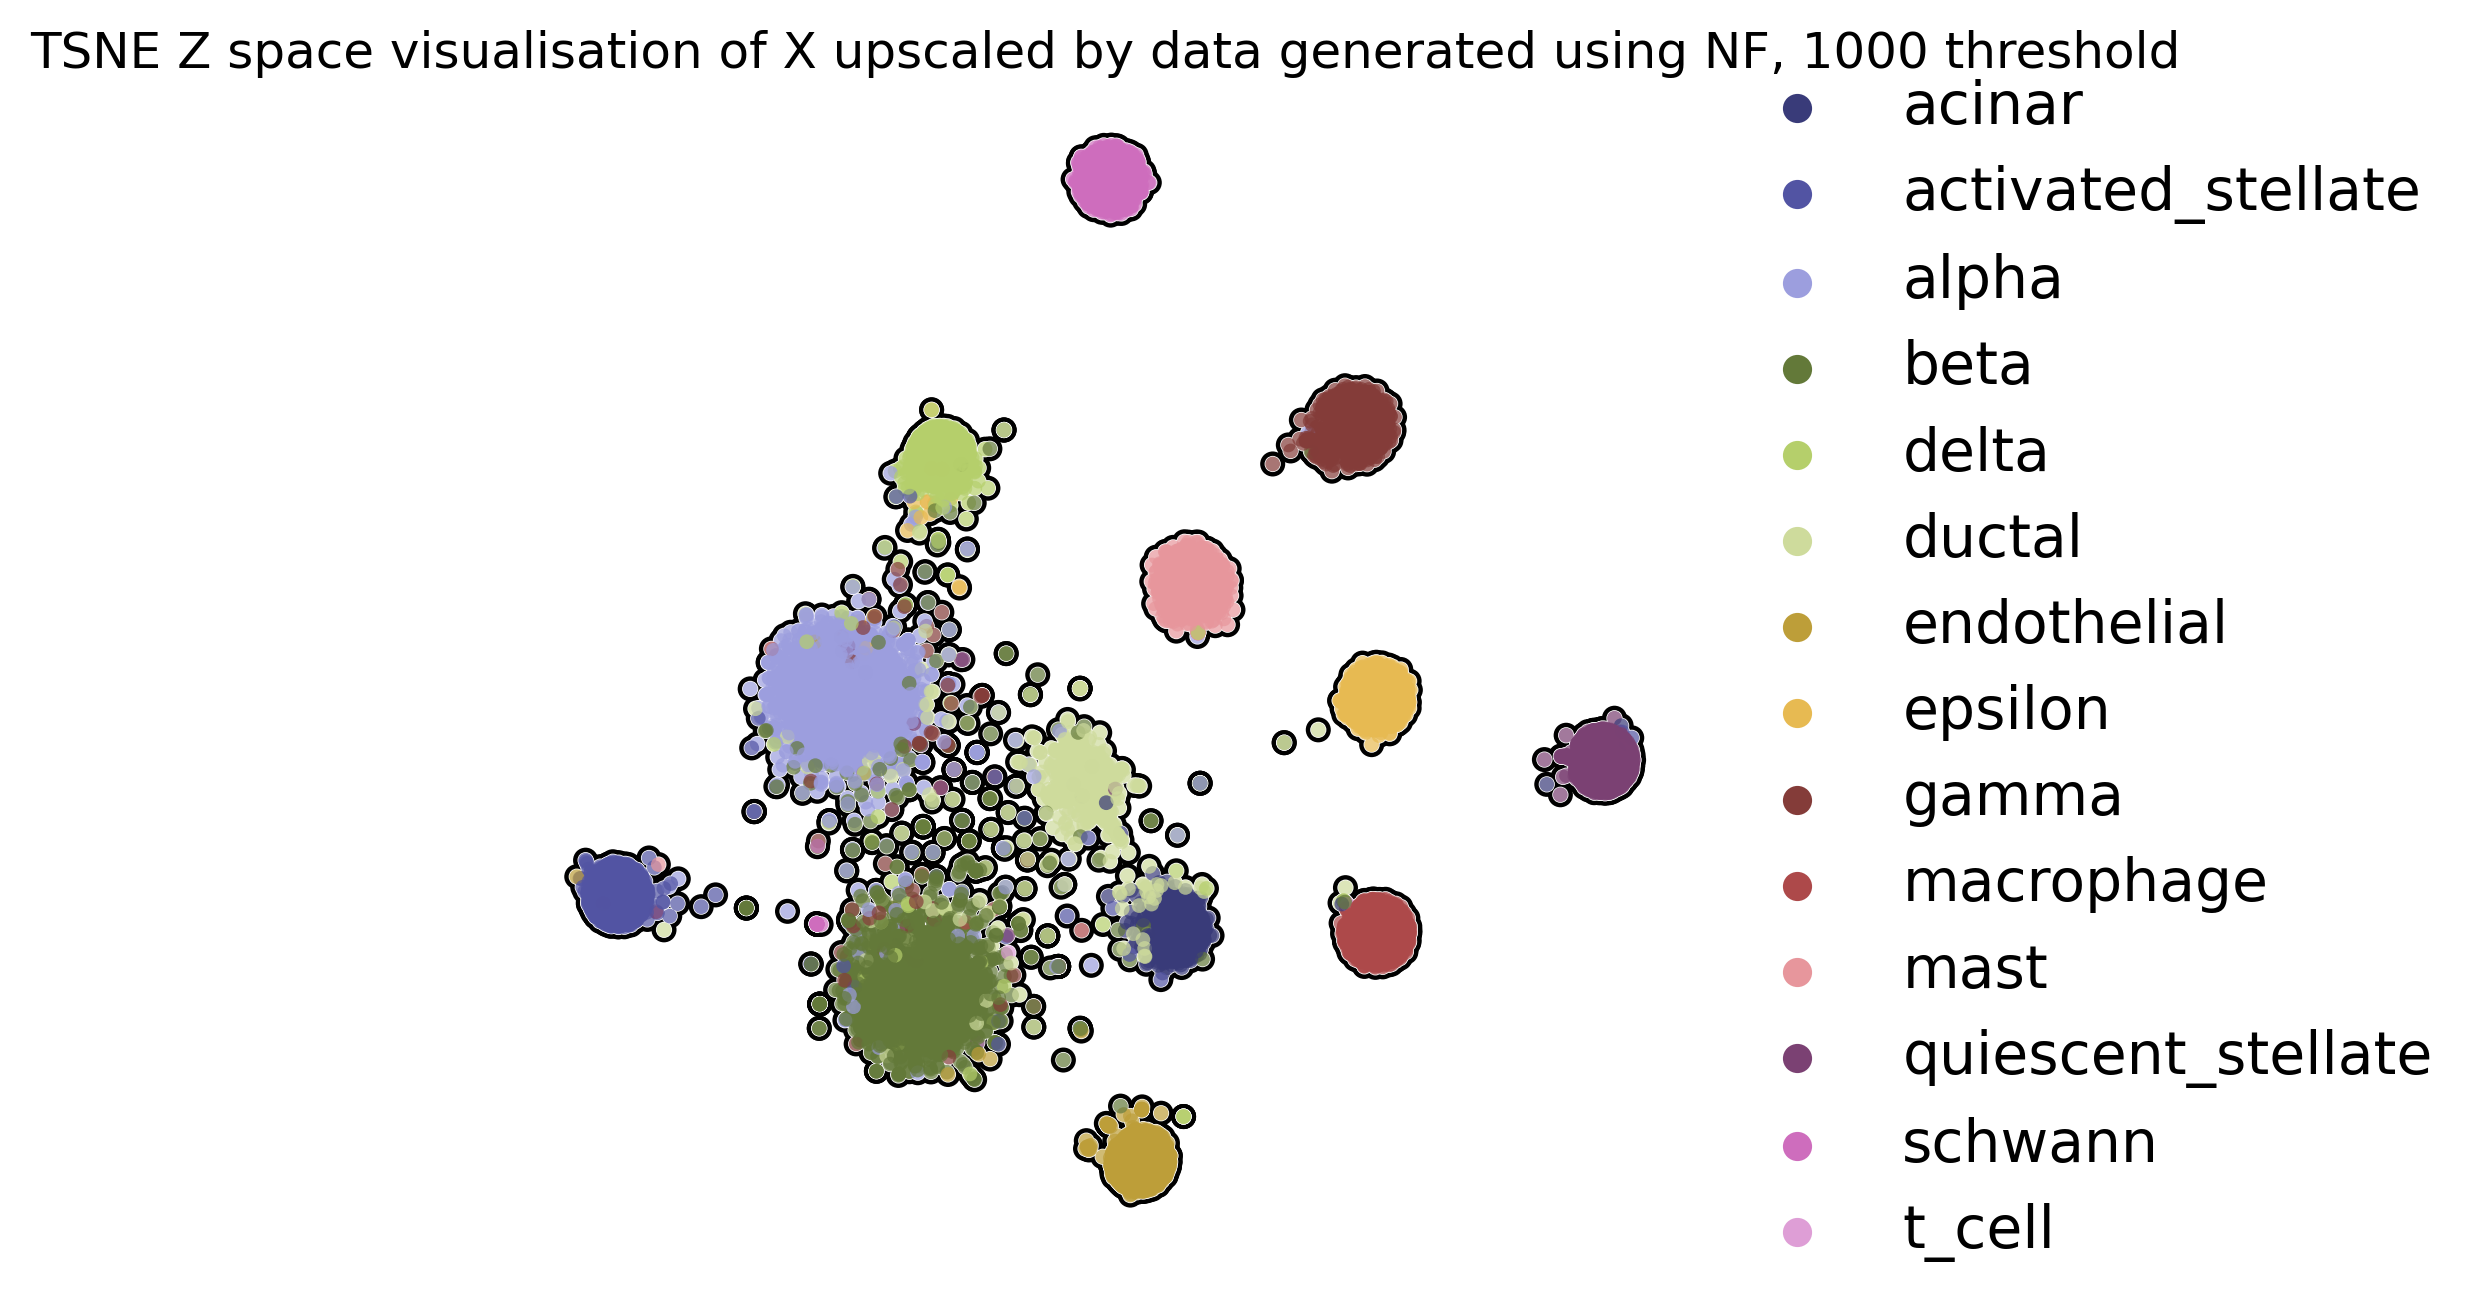

In [163]:
inv = flow(torch.from_numpy(data).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 1000, train_adata_pp.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 1000 threshold")

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


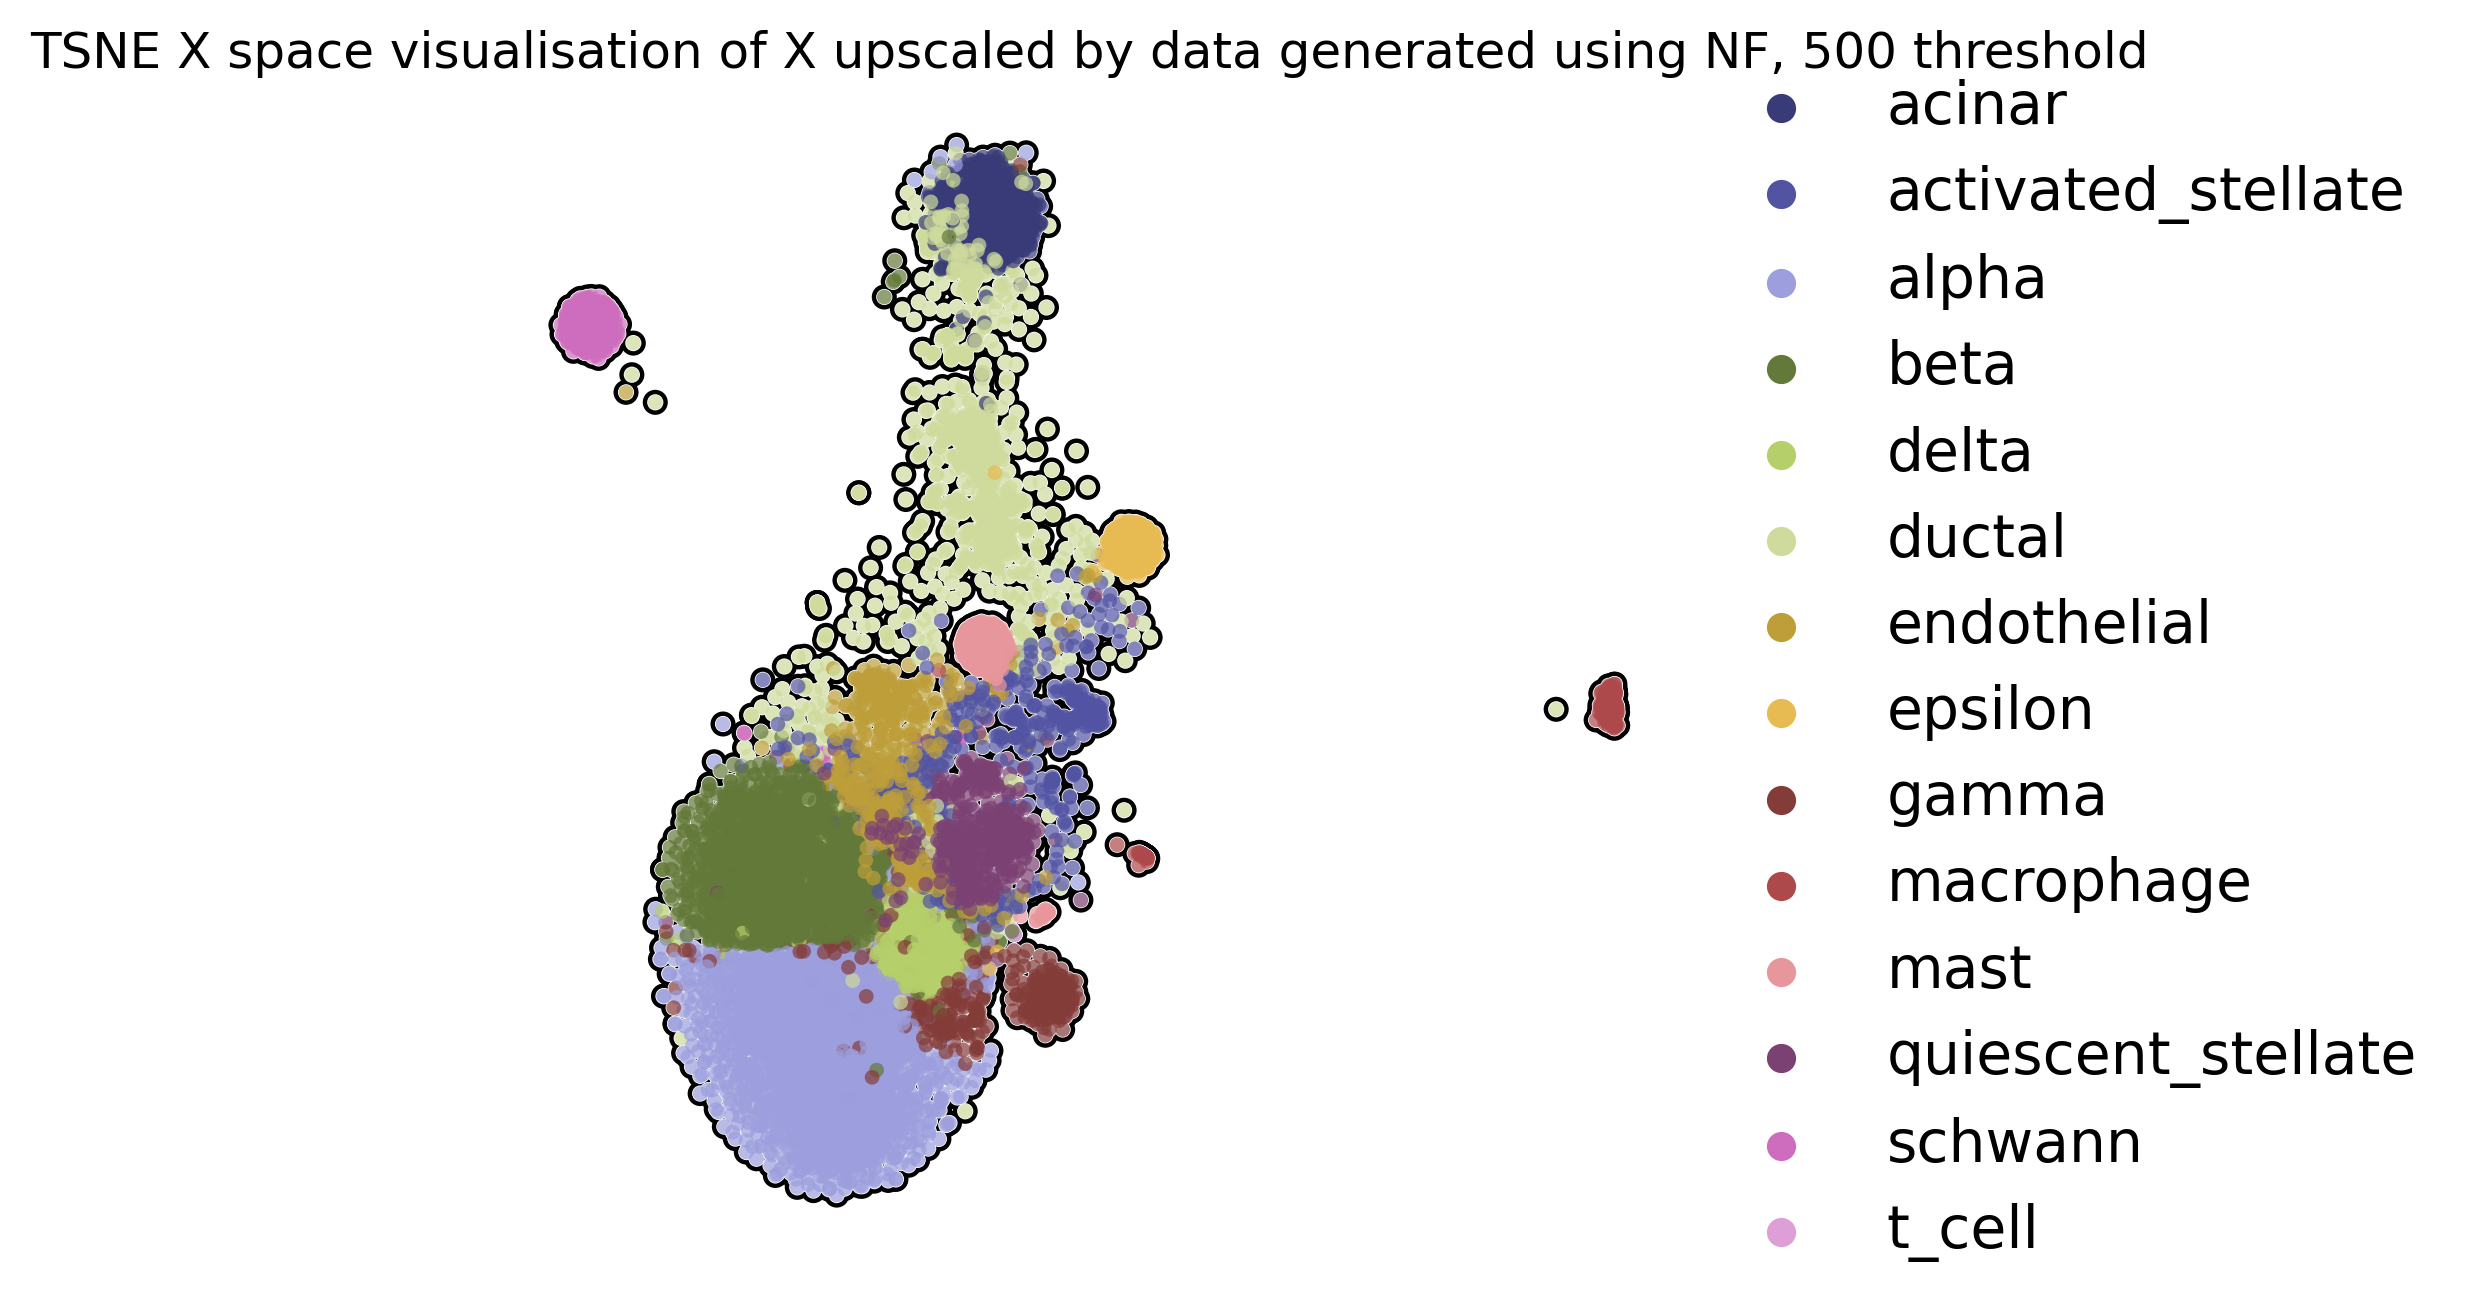

In [164]:
generated_data, generated_labels = generate_data(freq, 500, train_adata_pp.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 500 threshold")

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


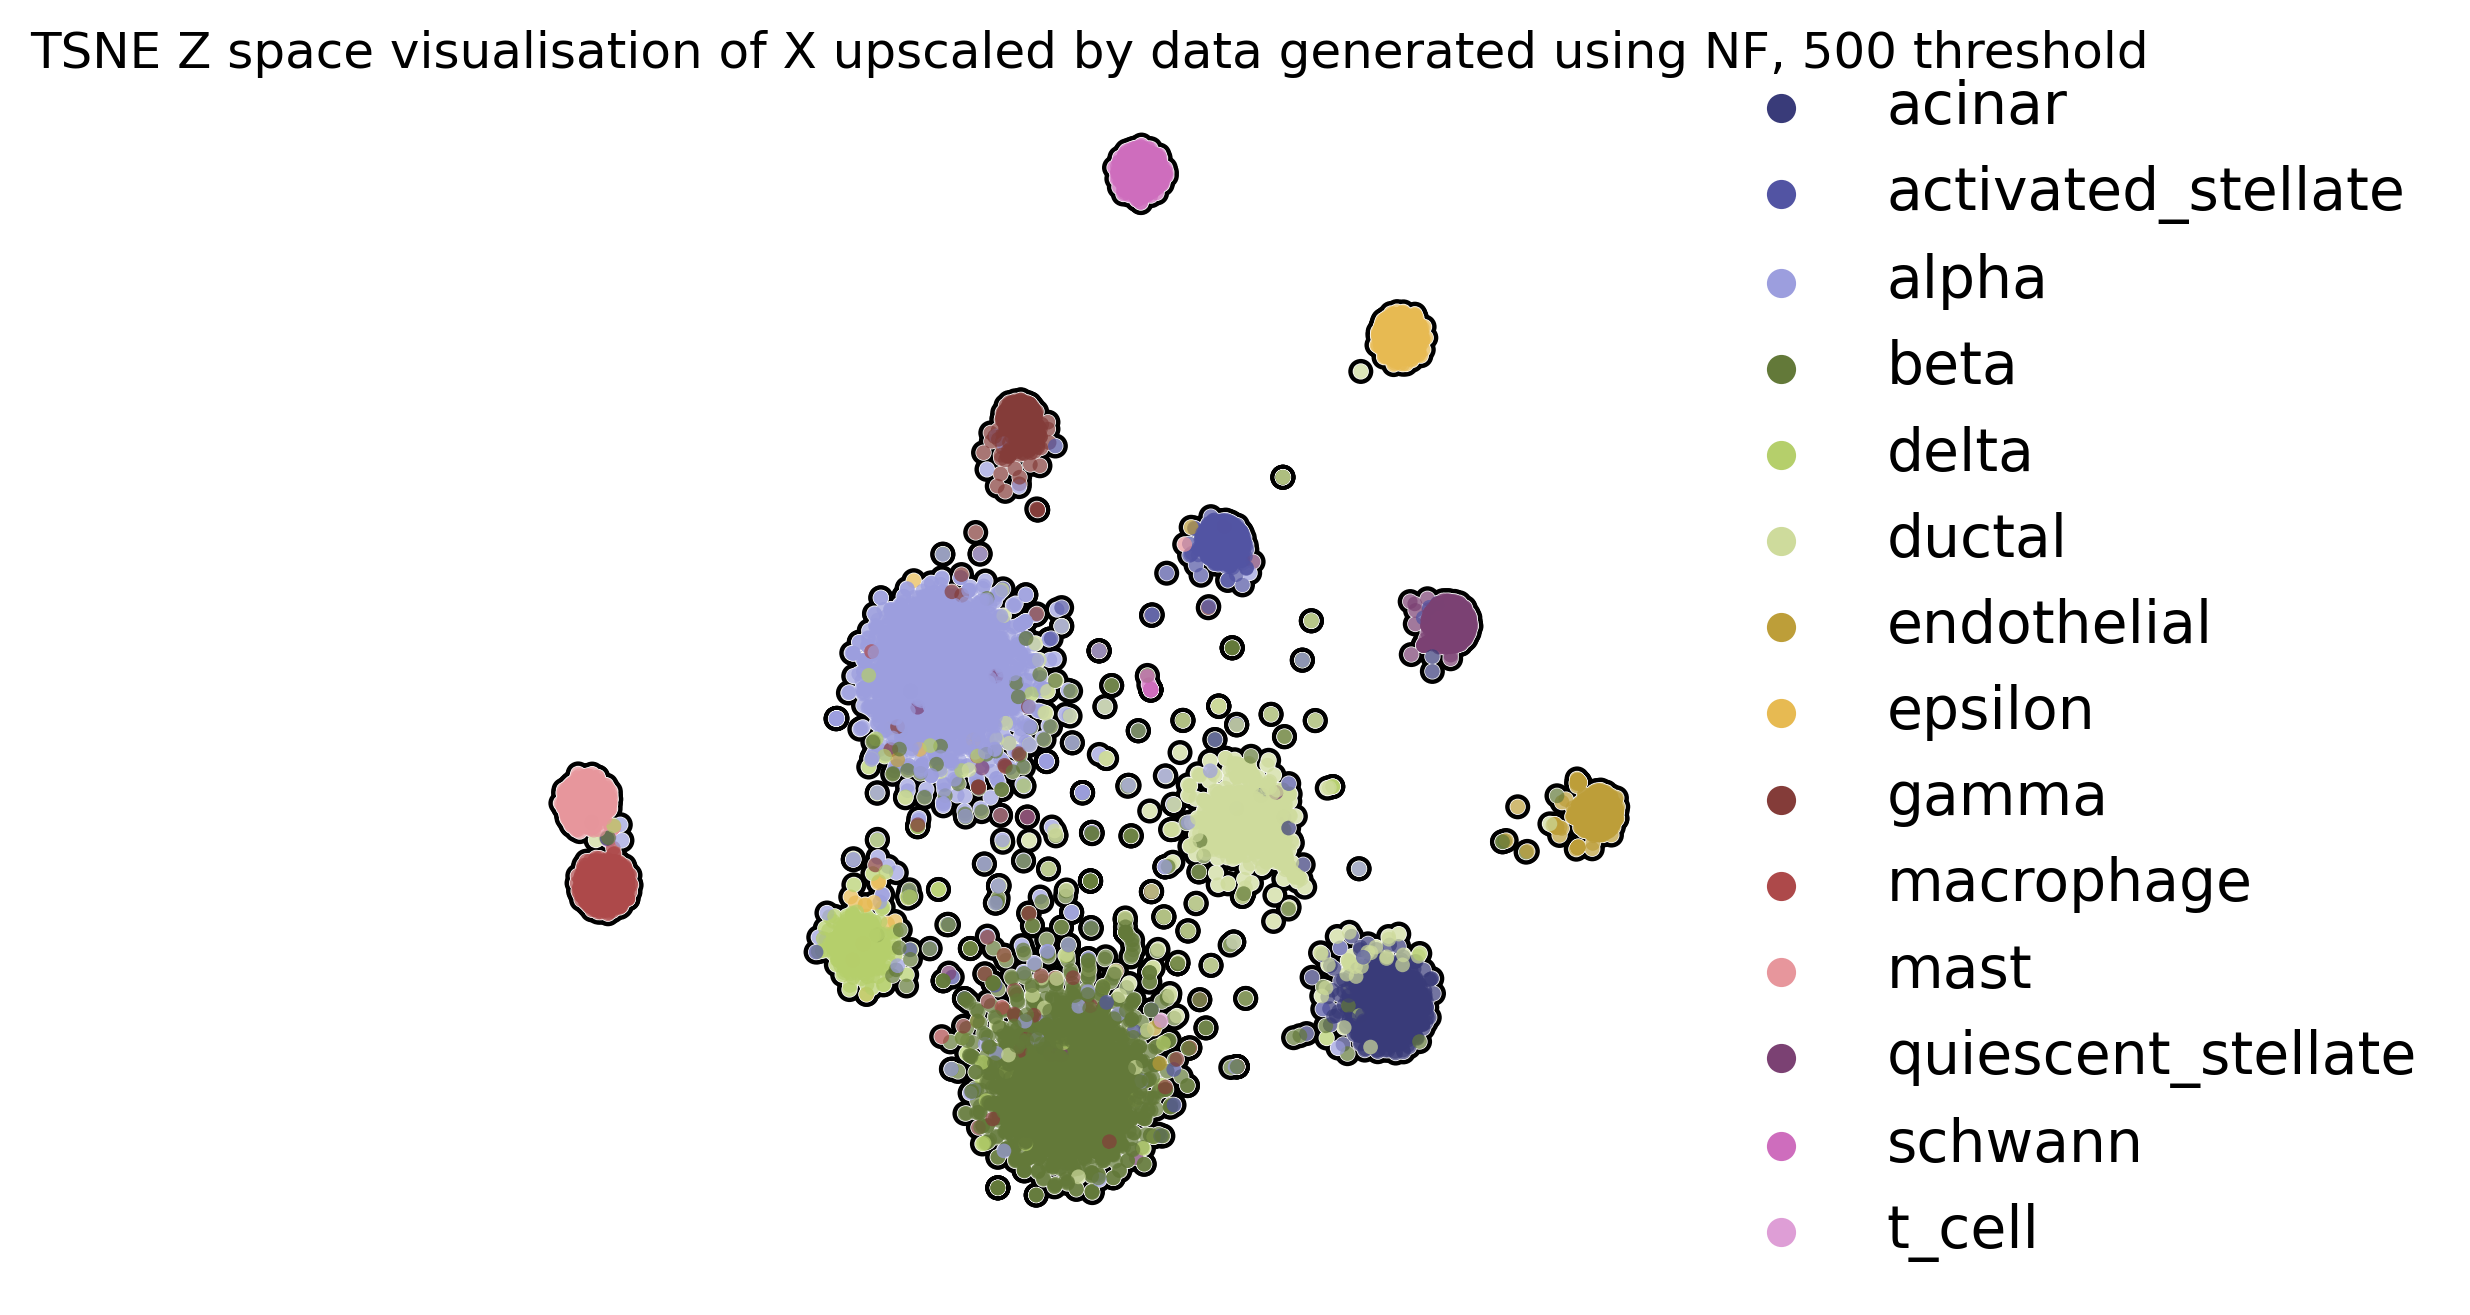

In [165]:
inv = flow(torch.from_numpy(data).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 500, train_adata_pp.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 500 threshold")

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


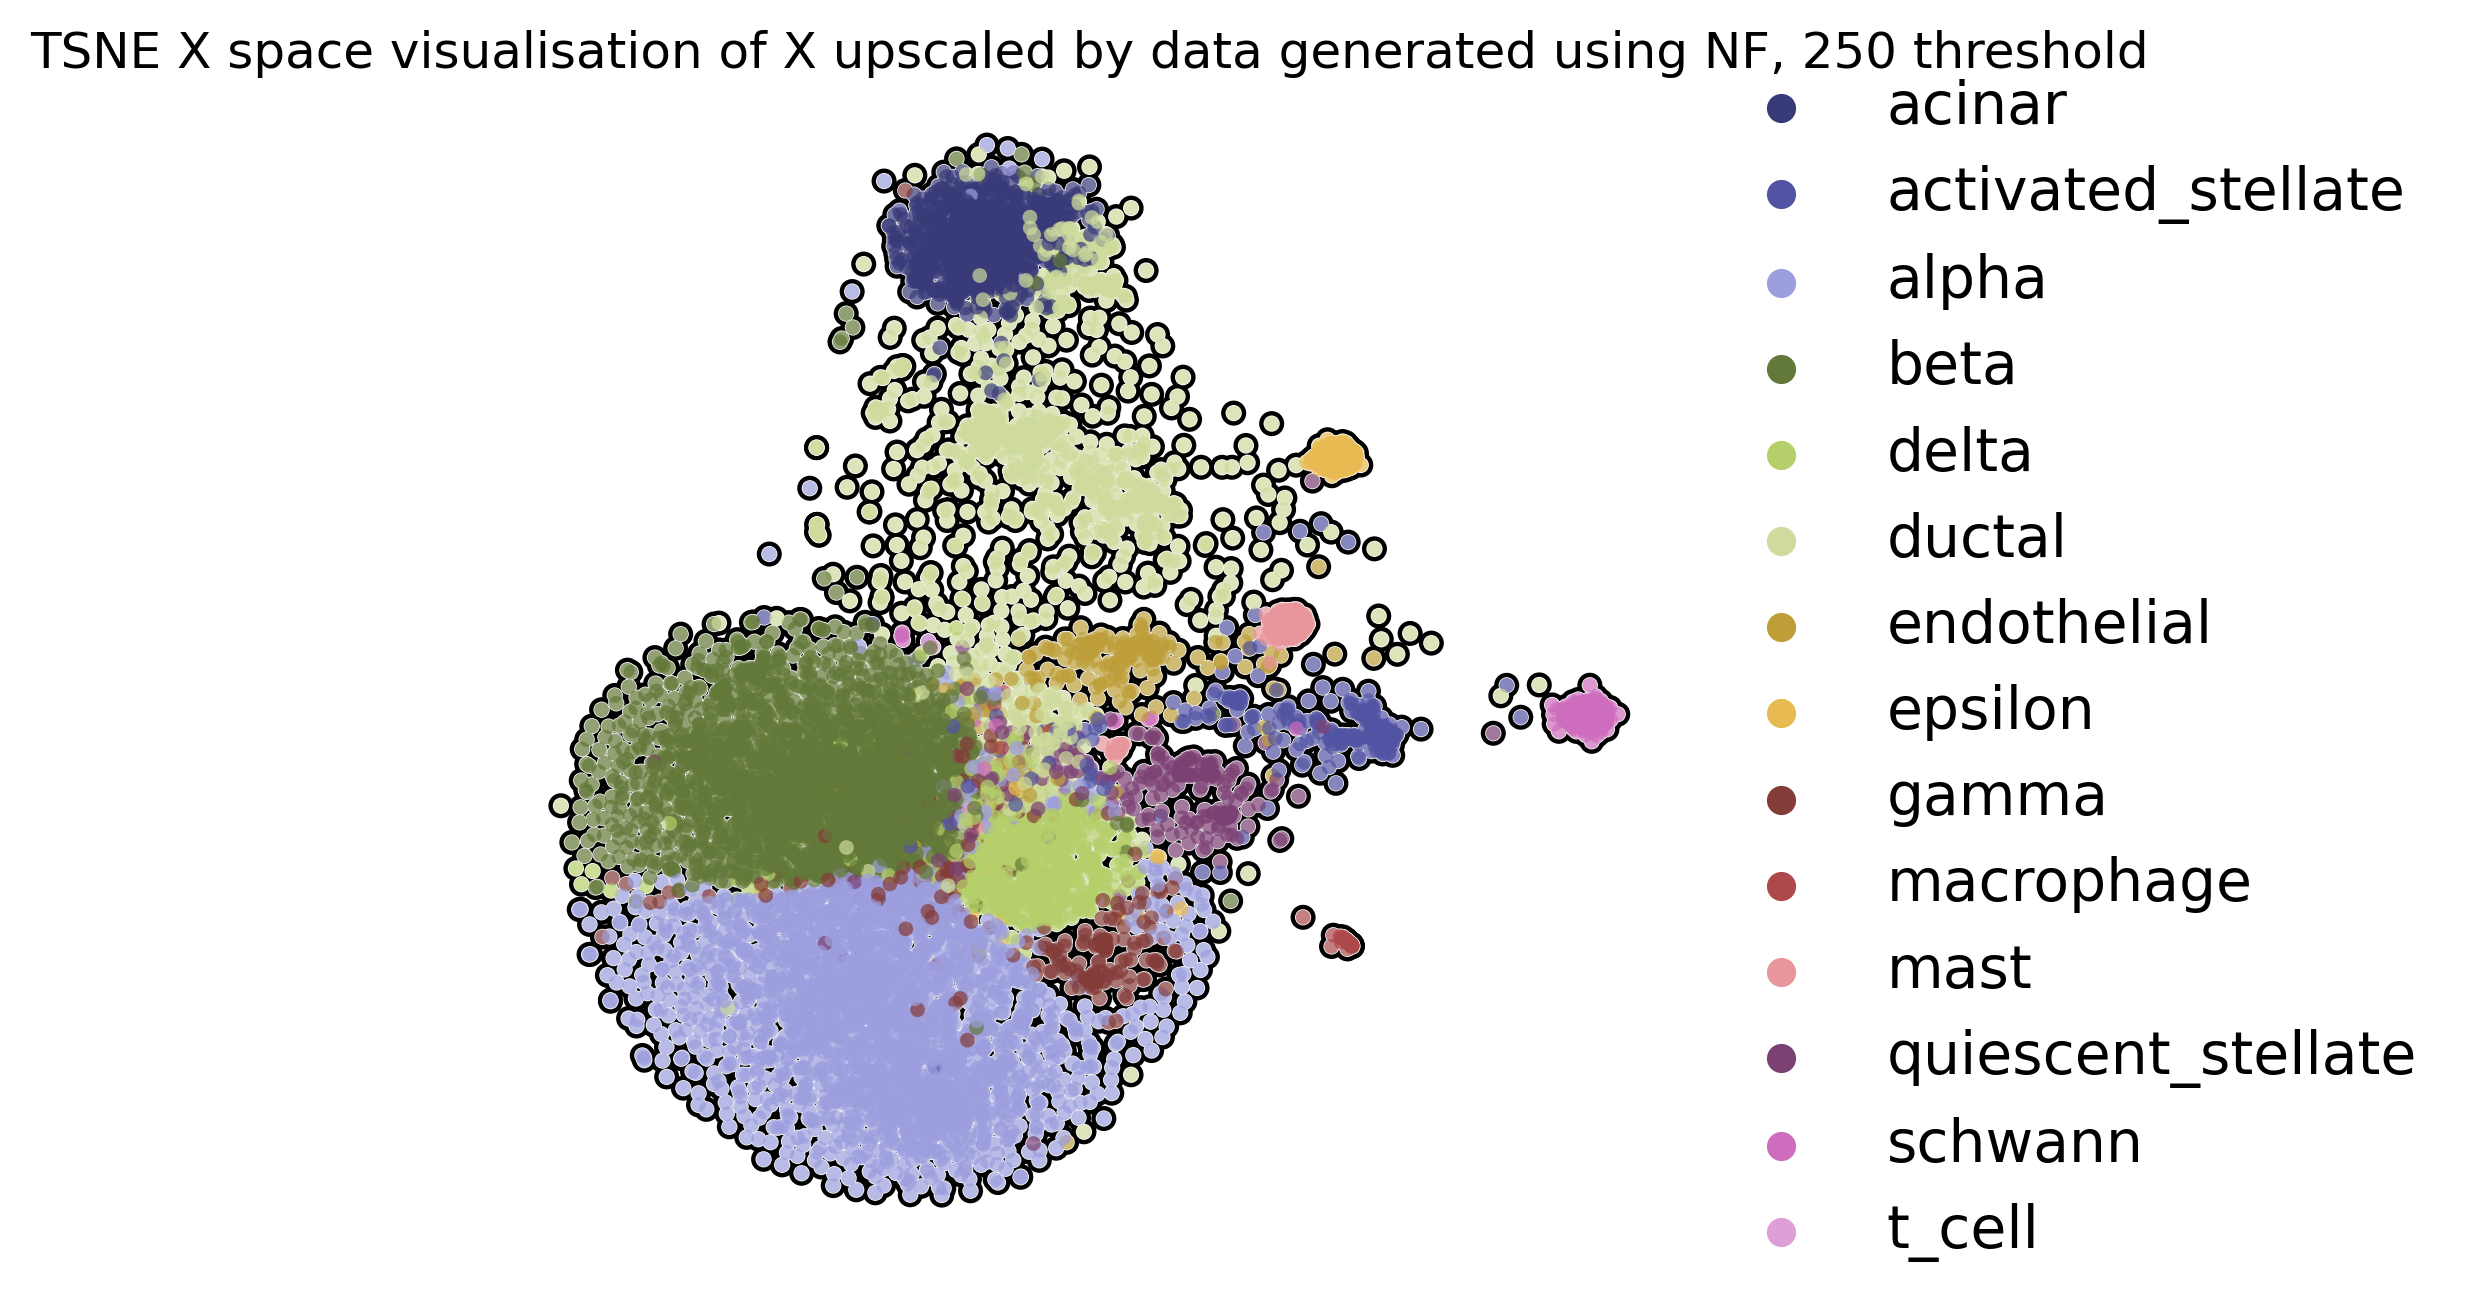

In [166]:
generated_data, generated_labels = generate_data(freq, 250, train_adata_pp.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 250 threshold")

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


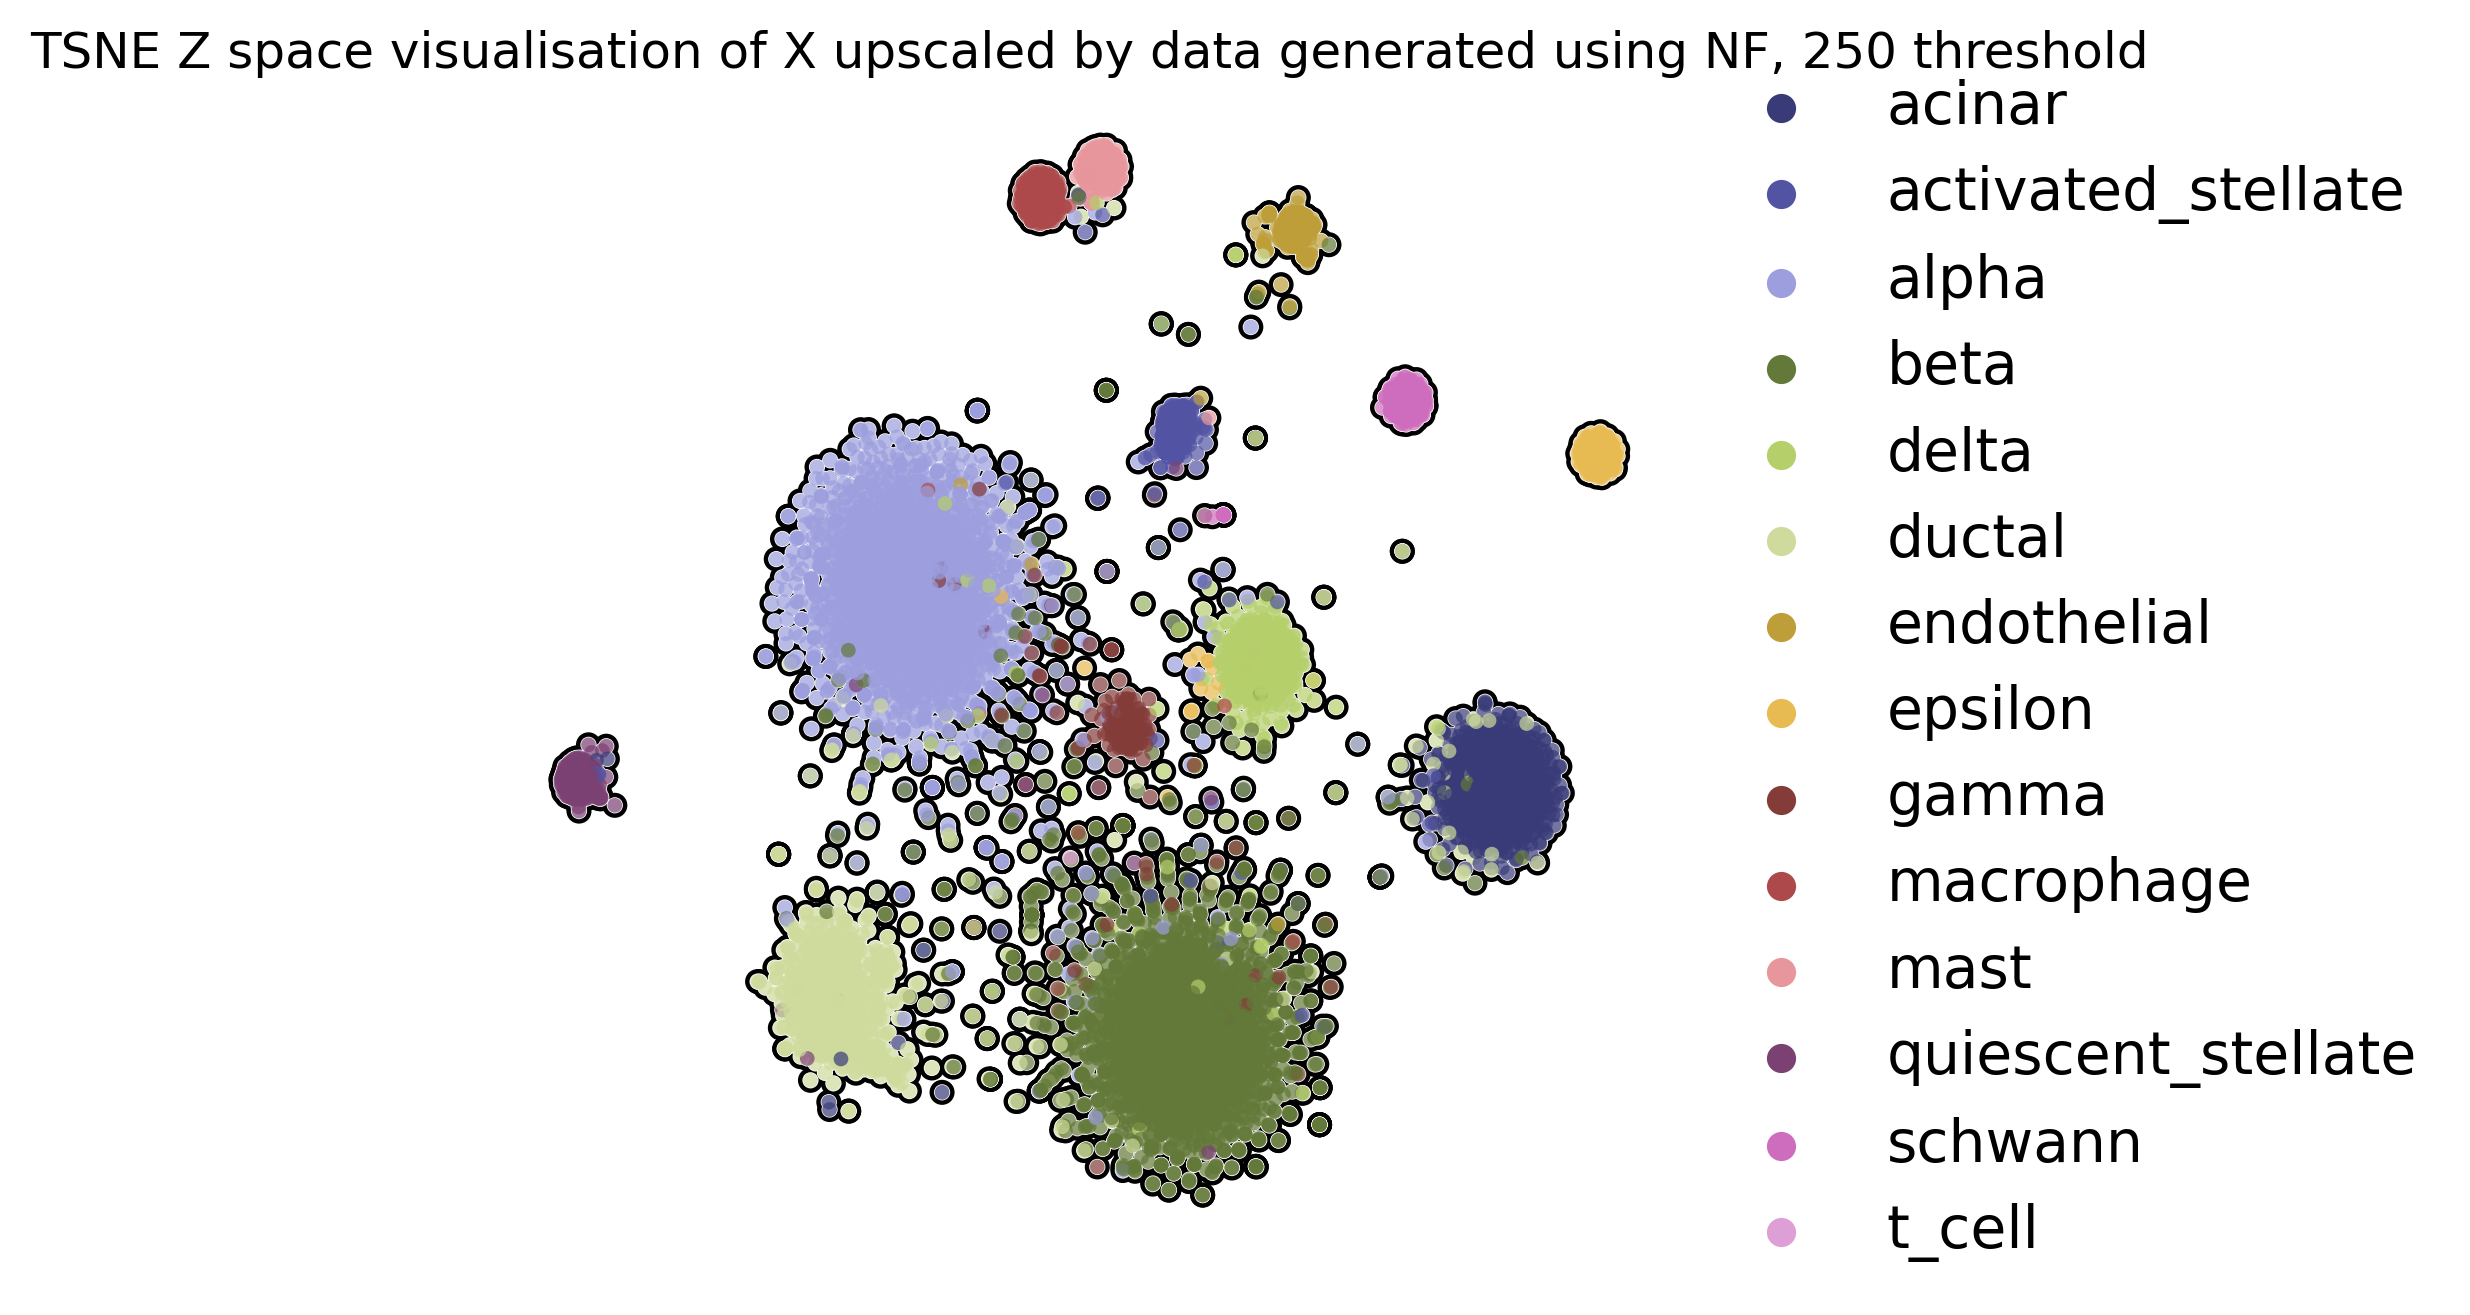

In [167]:
inv = flow(torch.from_numpy(data).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 250, train_adata_pp.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 250 threshold")

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


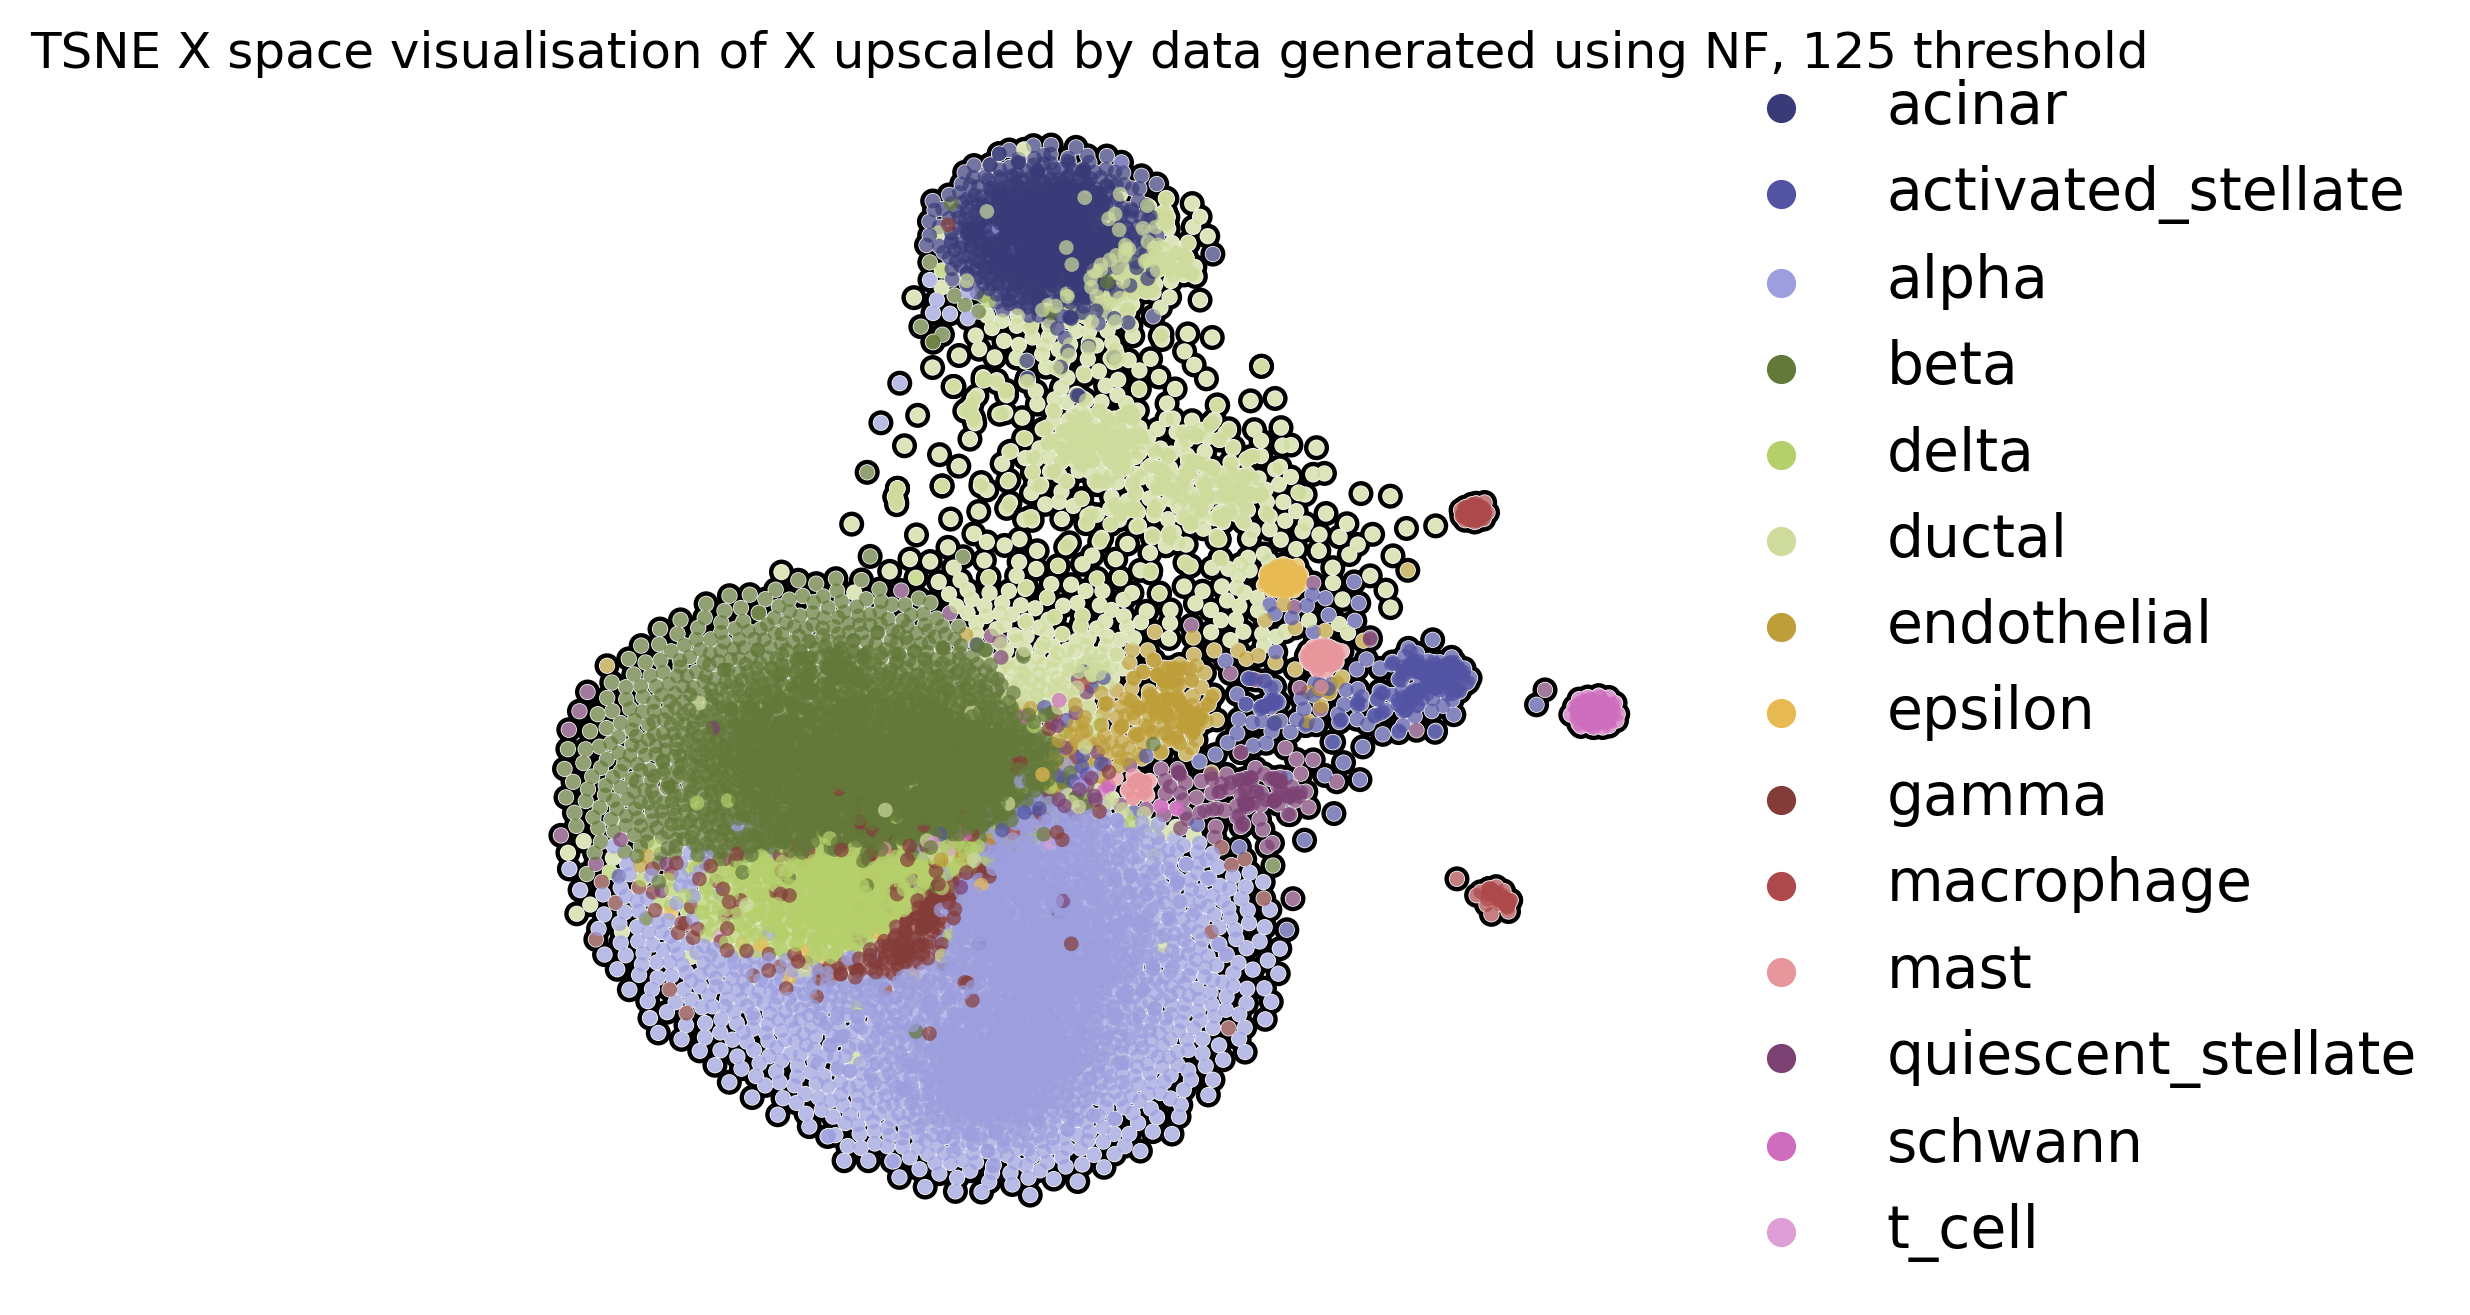

In [168]:
generated_data, generated_labels = generate_data(freq, 125, train_adata_pp.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 125 threshold")

/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


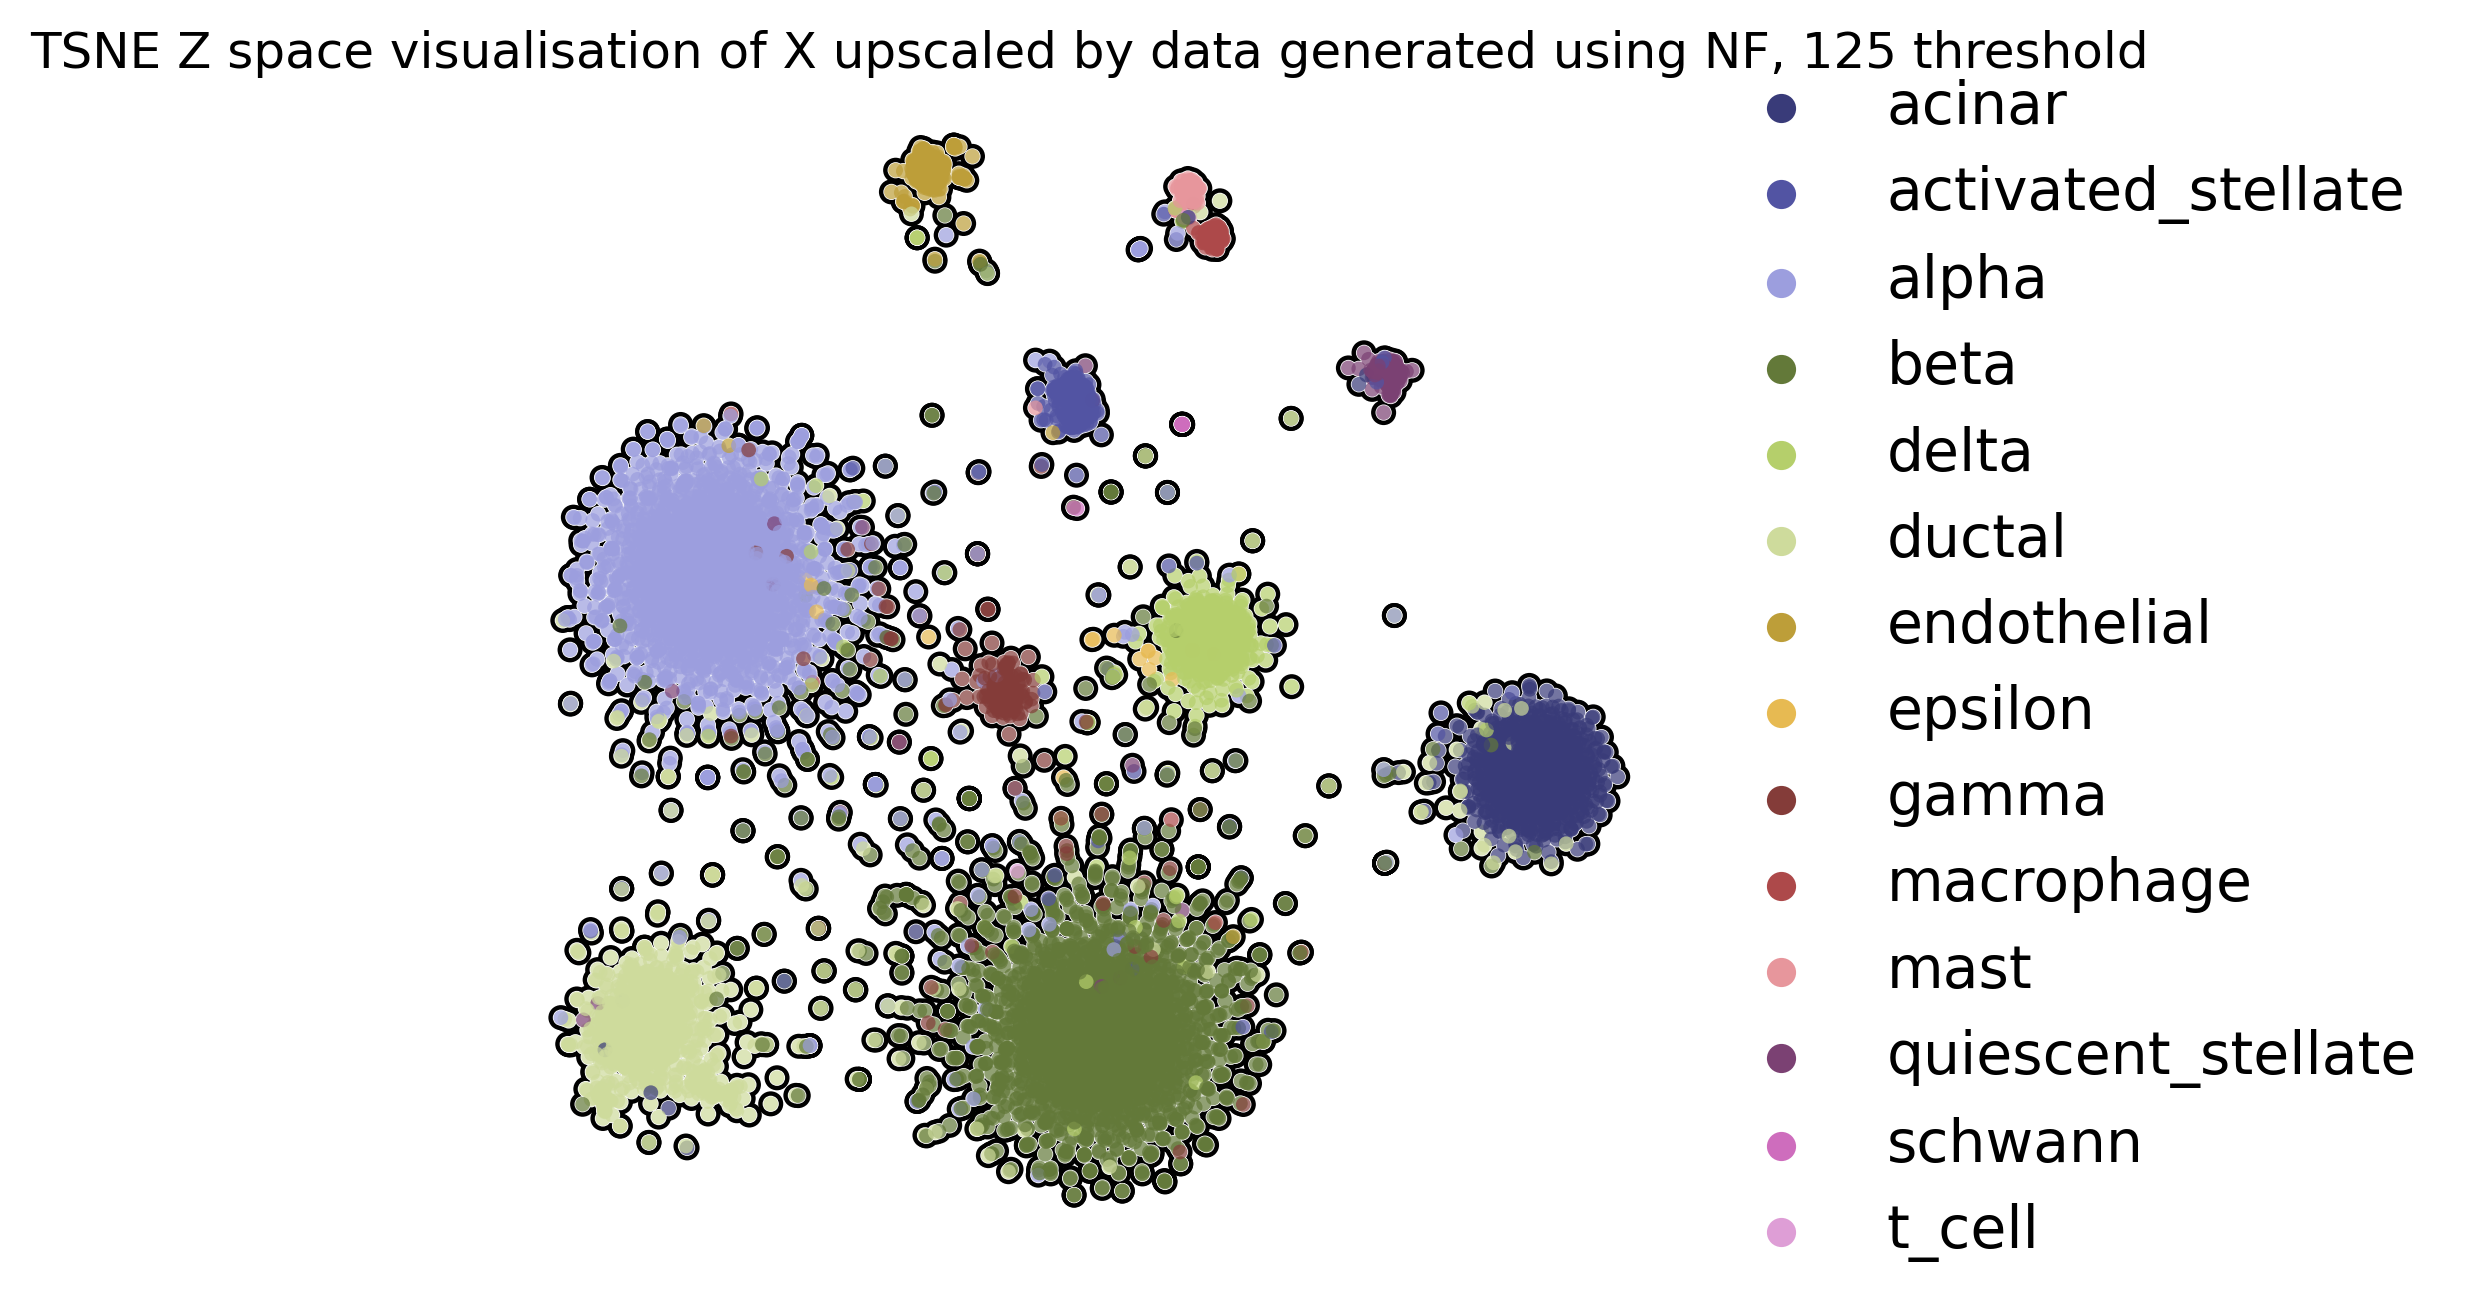

In [169]:
inv = flow(torch.from_numpy(data).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 125, train_adata_pp.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 125 threshold")